Agent

In [2]:
# Final version for the agent class.

import numpy as np 

actionSpace = {'U': (-1,0), 'D': (1,0), 'L': (0,-1), 'R': (0,1)}     # Action space, actions as movements

class Agent(object):                                                 # define my agent class    
    def __init__(self, maze, alpha=0.15, randomFactor=0.2):          # default random vales 80% exploting / 20% exploring. alpha
        self.stateHistory = [((0,0), 0)]                             # state, reward pairs. 
        self.G = {}                                                  # present value of expected future rewards      
        self.randomFactor = randomFactor
        self.alpha = alpha   
        self.initReward(maze.allowedStates)  

    def chooseAction(self, state, allowedMoves):                    # encoding physics into the environment
        maxG = -10e15                                               # basis for comparison in the first move
        nextMove = None 
        randomN = np.random.random()                                # pick a number from a random distribution, compares with random factor
        if randomN < self.randomFactor:
            nextMove = np.random.choice(allowedMoves)          
        else:            
            for action in allowedMoves:                              # iterate over the allowed moves and look for the
                newState = tuple([sum(x) for x in zip(state, actionSpace[action])]) # approximation of the  reward for                                                        
                if self.G[newState] >= maxG:                         # the new state, and then we compare it with our
                    maxG = self.G[newState]                          # best known reward
                    nextMove = action                                # if it is good we save it as our best reward and pick
        return nextMove                                              # the next move as the respective action.

    def initReward(self, allowedStates):
        for state in allowedStates:     
            self.G[state] = np.random.uniform(low=-1.0, high=-0.1)
            
            
    def updateStateHistory(self, state, reward):           # To update our stateHistory, we want to pass in the new state
        self.stateHistory.append((state, reward))          # and reward, and we simply use the append function
                                                           # to append the state reward tuple to our list.         


    def learn(self):    #this is called at the end of the episode when the agent has finished running the maze. 
        target = 0      # we only learn when we beat the maze

        for prev, reward in reversed(self.stateHistory):                    
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])            
            target += reward

        self.stateHistory = []
        self.randomFactor -= 10e-5                        # decrease the random factor at every step, gradually go from exploration to exploitation.

        

    def printG(self):
        for i in range(6):            
            for j in range(6):
                if (i,j) in self.G.keys():
                    print('%.6f' % self.G[(i,j)], end='\t')
                else:
                    print('X', end='\t\t')
            print('\n')



Maze

In [3]:
# 10 X 10 

import numpy as np
actionSpace = {'U': (-1,0), 'D': (1,0), 'L': (0,-1), 'R': (0,1)}  # action space

class Maze(object):
    def __init__(self):        
        self.maze = np.zeros((10,10)) # 6x6 maze - exit at 5,5
        self.maze[5, :5] = 1 
        self.maze[6, :6] = 1 
        self.maze[7, :6] = 1 
        self.maze[8, :6] = 1 
        # self.maze[:4, 5] = 1
        # self.maze[:4, 6] = 1
        self.maze[0:9, 7] = 1
        self.maze[0:9, 8] = 1
        self.maze[0:9, 9] = 1
        # self.maze[2, 2:] = 1
        # self.maze[3,2] = 1
        self.maze[0,0] = 2
        self.robotPosition = (0,0)
        self.steps = 0                                          # initial steps to zero
        self.constructAllowedStates()                           # construct the allowed states

    def printMaze(self):
        print('------------------------------------------')
        for row in self.maze:      
            for col in row:
                if col == 0:                                    # empty spaces
                    print('-', end='\t')
                elif col == 1:                                  # walls
                    print('X', end='\t')
                elif col == 2:                                  # robot
                    print('R', end='\t')                    
            print('\n')
        print('------------------------------------------')       
    
    def isAllowedMove(self, state, action):
        y, x = state
        y += actionSpace[action][0]                             # extract the coordinates from the action space
        x += actionSpace[action][1]
        if y < 0 or x < 0 or y > 9 or x > 9:                    # check if the move is allowed, inside the maze
            return False

        if self.maze[y,x] == 0 or self.maze[y,x] == 2:          #check if the new state is zero (or the actual position of the robot, because not moving is valid)
            return True
        else:
            return False

    def constructAllowedStates(self):                           # construct a dictionary and loop over the maze
        allowedStates= {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):                
                if self.maze[(y,x)] != 1:                       # It goes space by space checking if the actions are allowed, if yes it appended to allowed states dictionary
                    allowedStates[(y,x)] = []
                    for action in actionSpace:
                        if self.isAllowedMove((y,x), action):
                            allowedStates[(y,x)].append(action)
        self.allowedStates = allowedStates

    def updateMaze(self, action):                              
        y,x = self.robotPosition
        self.maze[y,x] = 0                                       # Get the current position of the robot and set to 0
        y += actionSpace[action][0]                              # read the coordinates from the action space diccionary 
        x += actionSpace[action][1]               
        self.robotPosition = (y,x)                               # updates the position of the robot
        self.maze[y,x] = 2                                       # update the mze
        self.steps += 1                                          # adds a new step

    def isGameOver(self):                                        # Check if the position is in the exit.
        if self.robotPosition == (9,9):
            return True
        else:
            return False
    
    def getStateAndReward(self):                                 
        reward = self.giveReward()
        return self.robotPosition, reward

    def giveReward(self):                                        # Gives the reward of 0 if the robots is in the exit.
        if self.robotPosition == (9,9):
            return 0
        else:
            return -1
        
    def get_matrix(self):
        return self.maze
    


# Main funktion för att använda Agent + Miljö


Hyperparameter tuning: Sök fram ett så bra Alpha och randomFactor värde som möjligt för en agent att lösa 10x10 – 20% area labyrinten i så få steg som möjligt.
Tips: Använd ’for loops’

In [11]:
# Let's create our main function

import numpy as np
import matplotlib.pyplot as plt 

def randowmF_A():
    for f in range(0,9):
        f_random_number = 0.1 * f
        print("faktor num :",f_random_number)
        for a in range(0, 9):
            a_random_number = 0.1 * a
            print("alpha num :",a_random_number)
            maze = Maze()
            robot = Agent(maze, alpha=a_random_number, randomFactor=f_random_number)
            moveHistory = []      # keep track of the number of moves.
            for i in range(5000): # number of games
                if i % 1000 == 0:
                    # print(i)
                    x=0      # just to know is running.
                while not maze.isGameOver():     # while the game is not over
                    state, _ = maze.getStateAndReward()   # gets state and reward
                    action = robot.chooseAction(state, maze.allowedStates[state]) # update the actions
                    maze.updateMaze(action)
                    state, reward = maze.getStateAndReward()
                    robot.updateStateHistory(state, reward)
                    if maze.steps > 1000:                  # cut prematurely to avoid infinite looping
                        maze.robotPosition = (9,9)
                robot.learn()                              # learns
                moveHistory.append(maze.steps)             # keep tracking of steps
                maze = Maze()  
            print("total steg",len(moveHistory) )
            print("agenten minst steg: ",min(moveHistory))                            # resets the maze but not the agent.

            # A plot to show how our agent is doing!
            plt.figure(figsize=(16, 8))
            plt.subplot(211)
            plt.semilogy(moveHistory, 'b--')
            plt.legend(['alpha=0.1'])


In [ ]:
# Let's create our main function

import numpy as np
import matplotlib.pyplot as plt 
def randomF_A():
    for f in range(0, 9):
        f_random_number = 0.1 * f
        print("Faktor num:", f_random_number)
        for a in range(0, 9):
            a_random_number = 0.1 * a
            print("Alpha num:", a_random_number)

            total_steps_list = []  # To store the total steps for each game
            min_steps_list = []    # To store the minimum steps for each game

            for i in range(5000):  # number of games
                if i % 1000 == 0:
                    print("Running game", i)
                maze = Maze()
                robot = Agent(maze, alpha=a_random_number, randomFactor=f_random_number)
                moveHistory = []  # keep track of the number of moves

                while not maze.isGameOver():
                    state, _ = maze.getStateAndReward()
                    action = robot.chooseAction(state, maze.allowedStates[state])
                    maze.updateMaze(action)
                    state, reward = maze.getStateAndReward()
                    robot.updateStateHistory(state, reward)
                    if maze.steps > 1000:
                        maze.robotPosition = (9, 9)

                robot.learn()
                moveHistory.append(maze.steps)
                maze = Maze()

            total_steps_list.append(sum(moveHistory))
            min_steps_list.append(min(moveHistory))

            print("Total steps:", sum(moveHistory))
            print("Agent's least steps in a game:", min(moveHistory))

            # A plot to show how our agent is doing!
            plt.figure(figsize=(16, 8))
            plt.subplot(211)
            plt.semilogy(moveHistory, 'b--')
            plt.legend([f'alpha={a_random_number}'])

            plt.show()

        print(f"Average total steps for Faktor={f_random_number}:", sum(total_steps_list) / len(total_steps_list))
        print(f"Average minimum steps for Faktor={f_random_number}:", sum(min_steps_list) / len(min_steps_list))

# Call the function
randomF_A()

faktor num : 0.0
alpha num : 0.0
total steg 5000
agenten minst steg:  1001
alpha num : 0.1
total steg 5000
agenten minst steg:  1001
alpha num : 0.2
total steg 5000
agenten minst steg:  1001
alpha num : 0.30000000000000004
total steg 5000
agenten minst steg:  1001
alpha num : 0.4
total steg 5000
agenten minst steg:  1001
alpha num : 0.5
total steg 5000
agenten minst steg:  18
alpha num : 0.6000000000000001
total steg 5000
agenten minst steg:  1001
alpha num : 0.7000000000000001
total steg 5000
agenten minst steg:  1001
alpha num : 0.8
total steg 5000
agenten minst steg:  18
faktor num : 0.1
alpha num : 0.0
total steg 5000
agenten minst steg:  1001
alpha num : 0.1
total steg 5000
agenten minst steg:  18
alpha num : 0.2
total steg 5000
agenten minst steg:  18
alpha num : 0.30000000000000004
total steg 5000
agenten minst steg:  18
alpha num : 0.4
total steg 5000
agenten minst steg:  18
alpha num : 0.5
total steg 5000
agenten minst steg:  18
alpha num : 0.6000000000000001
total steg 5000
a

C:\Users\Admin\AppData\Local\Temp\ipykernel_17904\2374057623.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 8))


total steg 5000
agenten minst steg:  18
alpha num : 0.4
total steg 5000
agenten minst steg:  18
alpha num : 0.5
total steg 5000
agenten minst steg:  18
alpha num : 0.6000000000000001
total steg 5000
agenten minst steg:  18
alpha num : 0.7000000000000001
total steg 5000
agenten minst steg:  18
alpha num : 0.8
total steg 5000
agenten minst steg:  18
faktor num : 0.30000000000000004
alpha num : 0.0
total steg 5000
agenten minst steg:  404
alpha num : 0.1
total steg 5000
agenten minst steg:  18
alpha num : 0.2
total steg 5000
agenten minst steg:  18
alpha num : 0.30000000000000004
total steg 5000
agenten minst steg:  18
alpha num : 0.4
total steg 5000
agenten minst steg:  18
alpha num : 0.5
total steg 5000
agenten minst steg:  18
alpha num : 0.6000000000000001
total steg 5000
agenten minst steg:  18
alpha num : 0.7000000000000001
total steg 5000
agenten minst steg:  18
alpha num : 0.8
total steg 5000
agenten minst steg:  18
faktor num : 0.4
alpha num : 0.0
total steg 5000
agenten minst ste

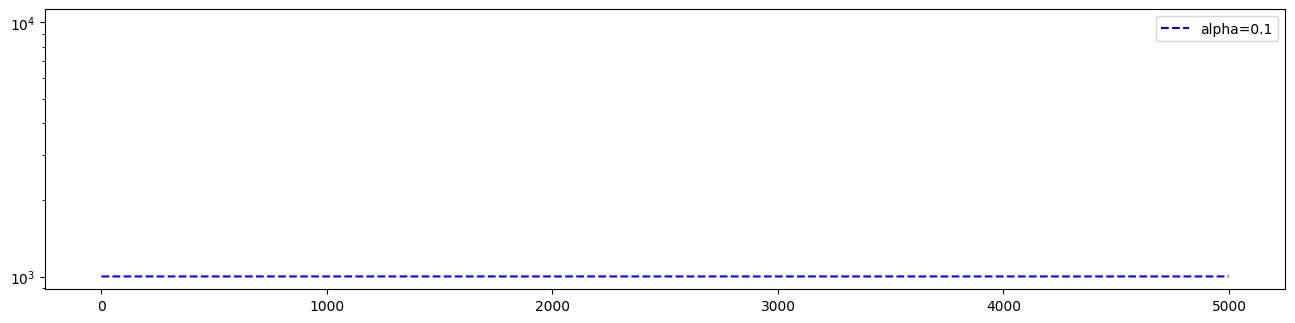

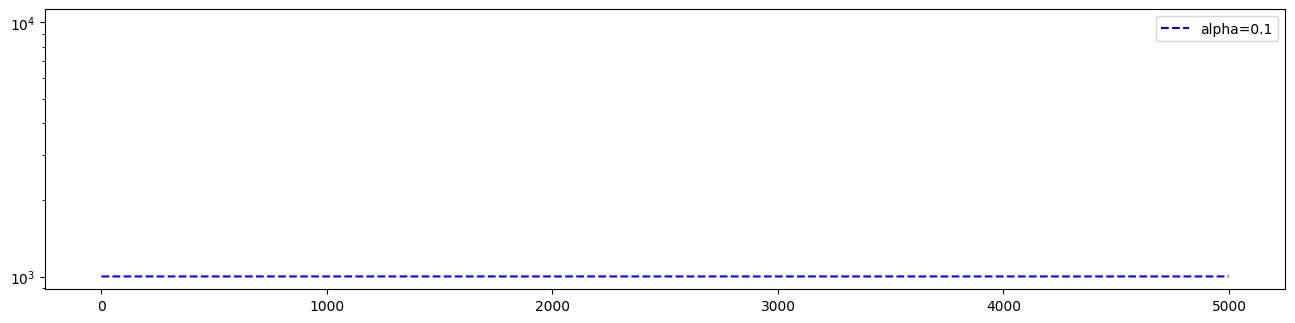

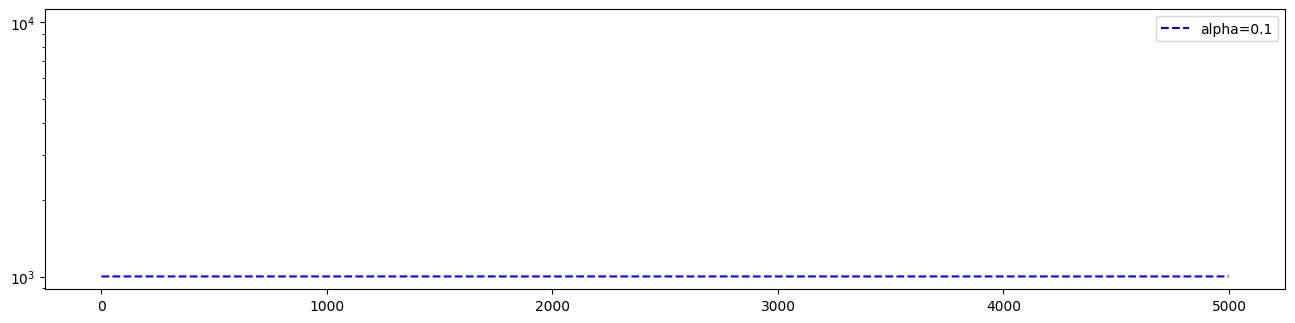

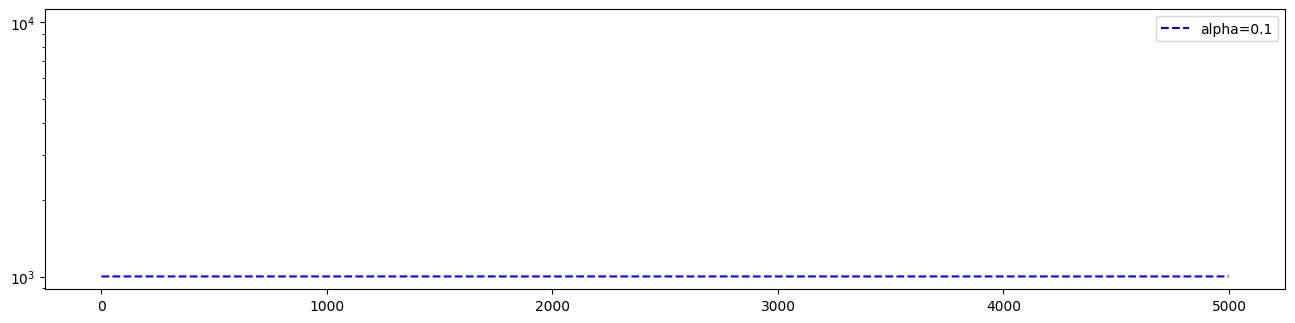

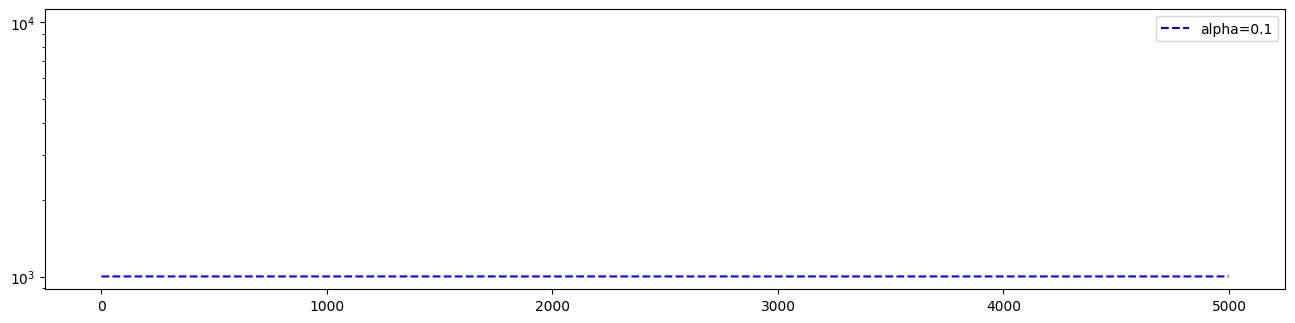

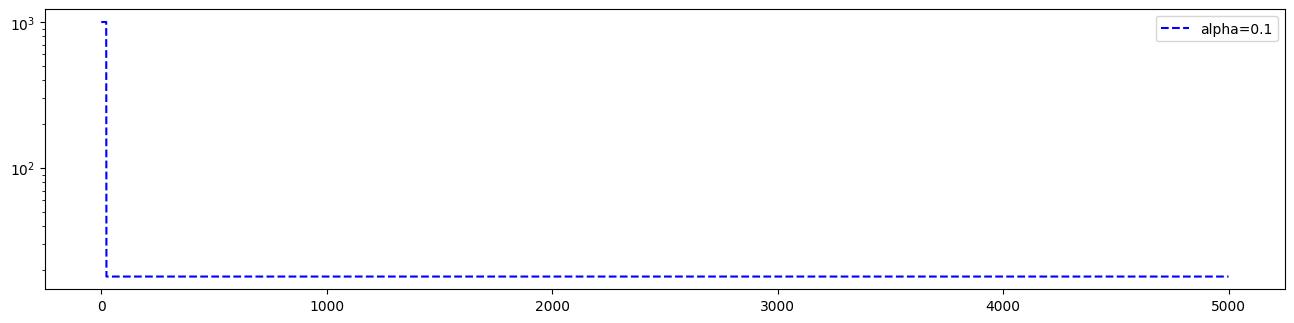

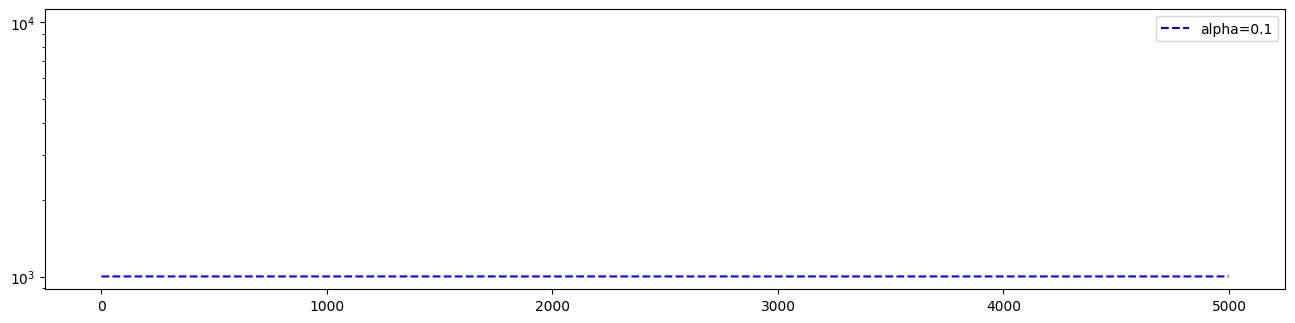

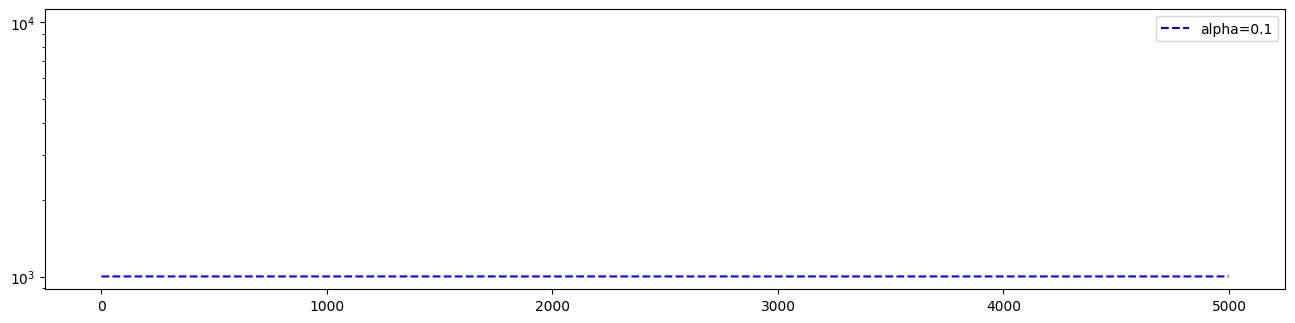

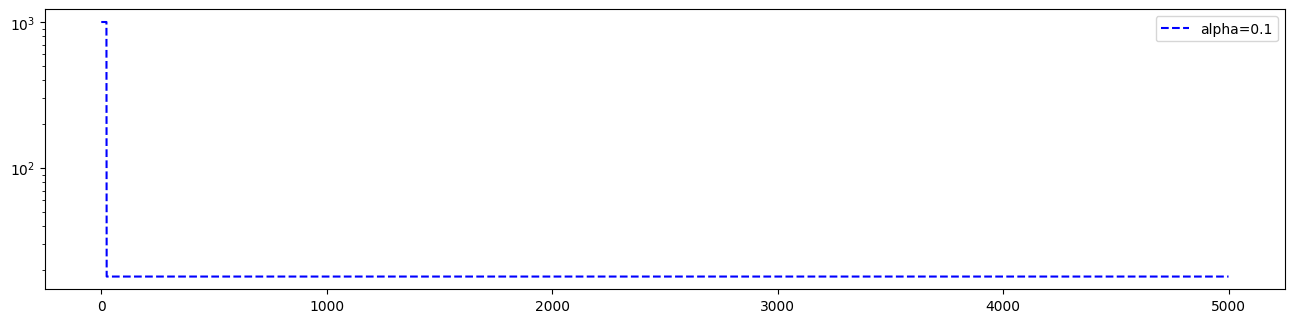

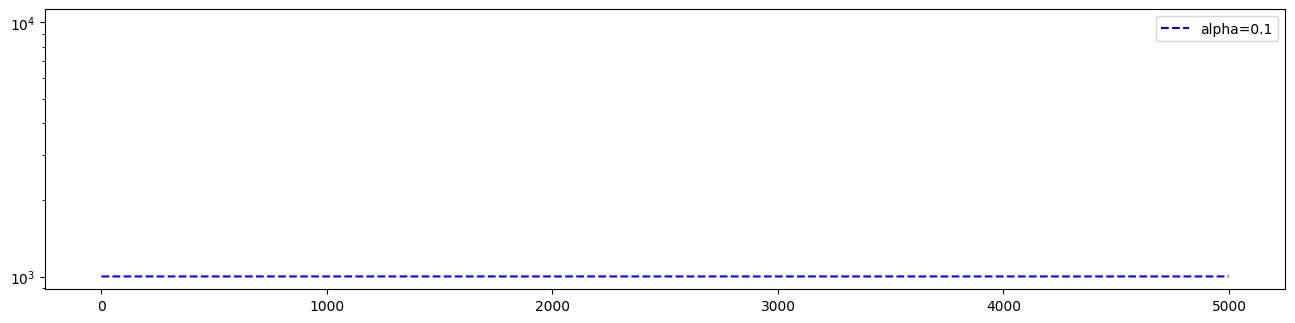

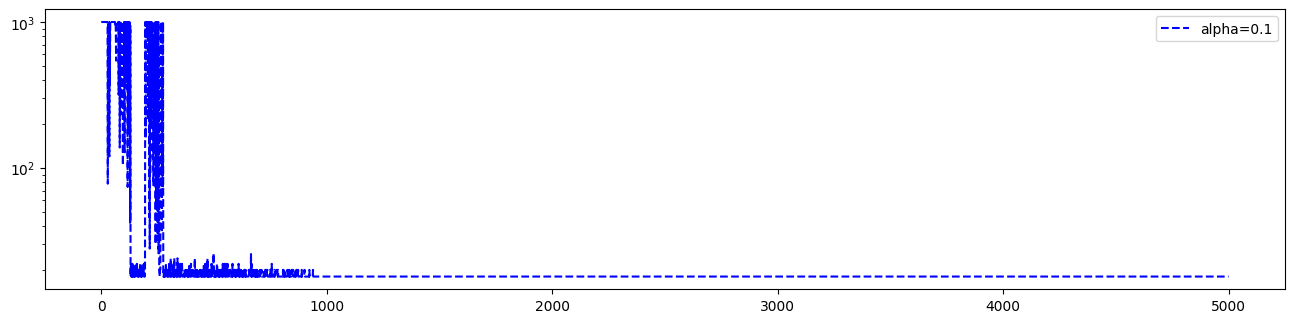

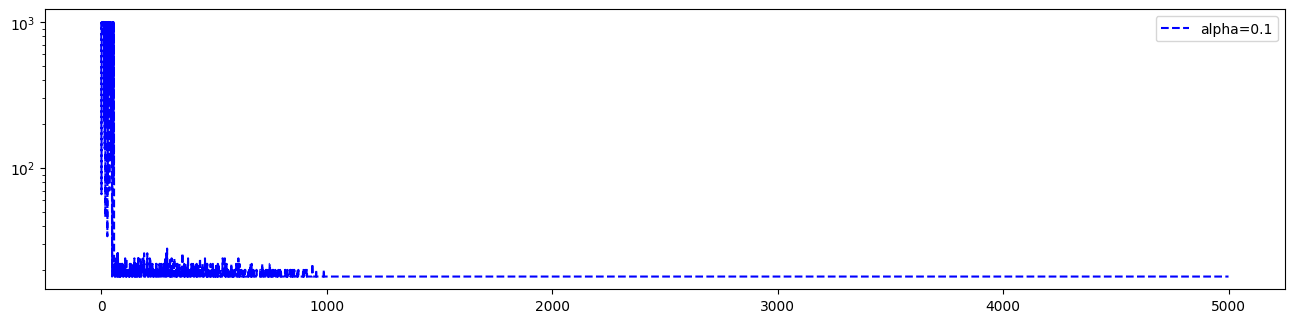

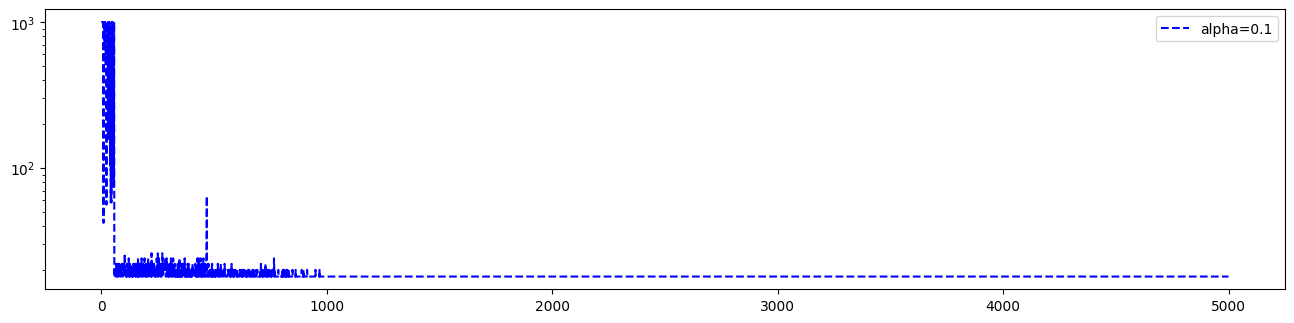

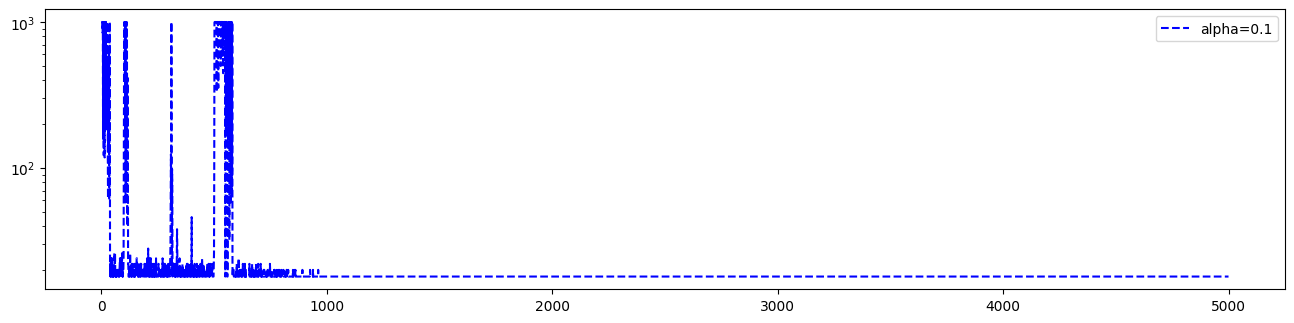

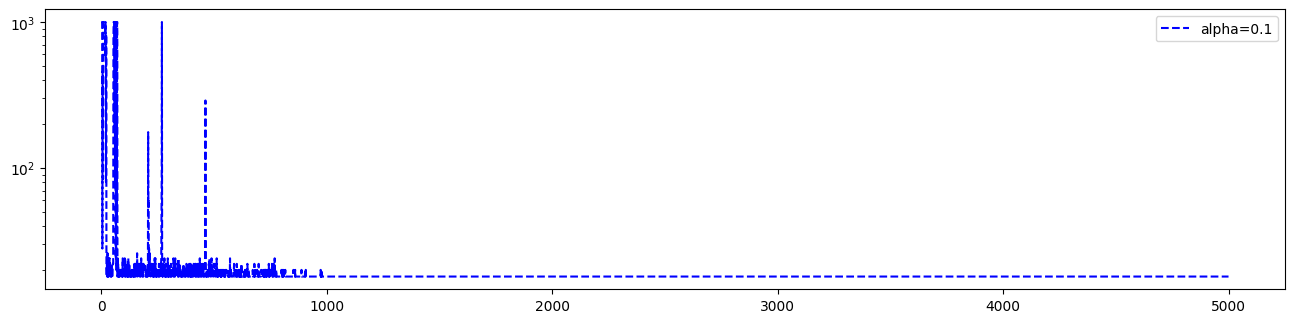

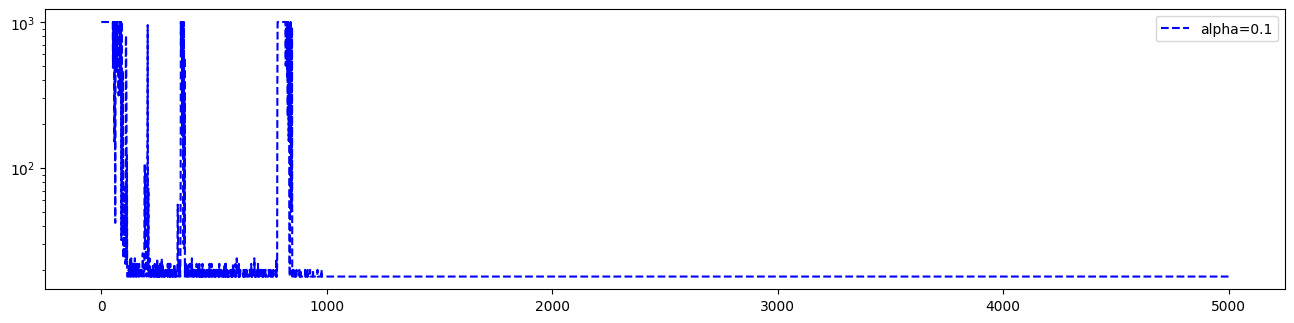

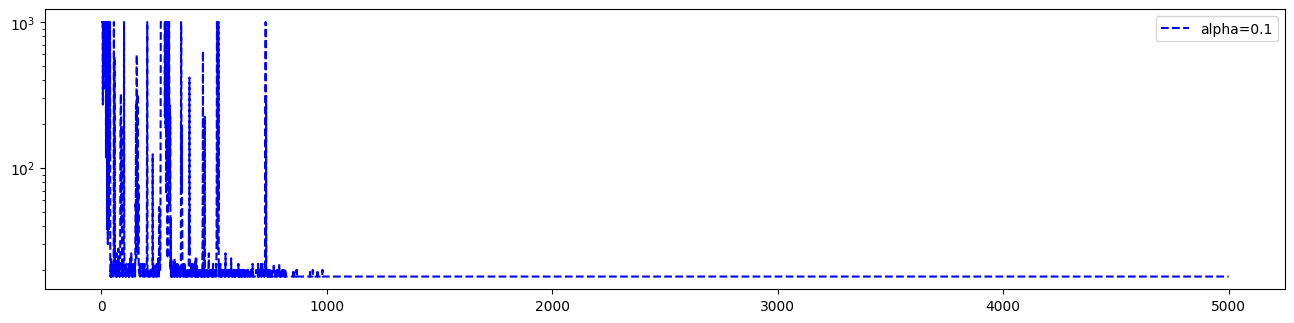

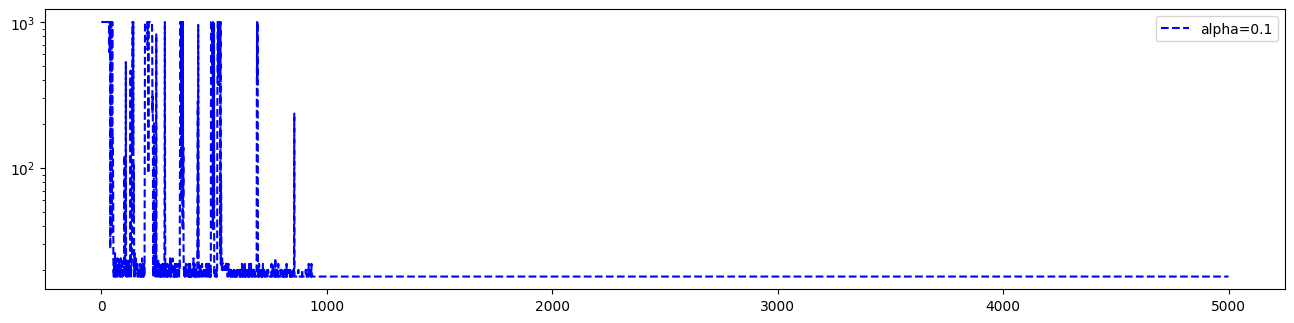

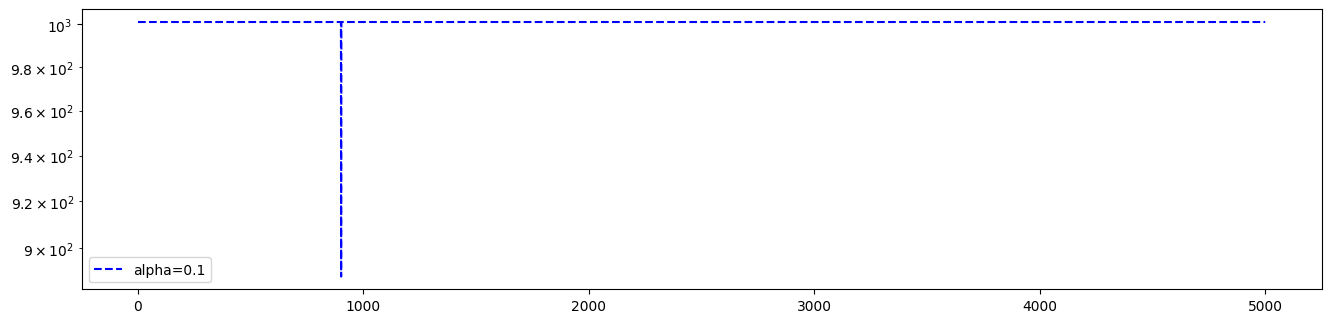

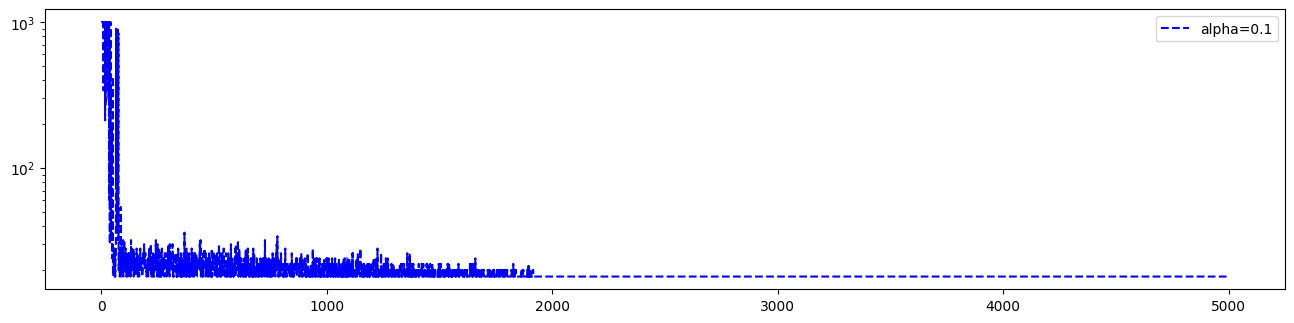

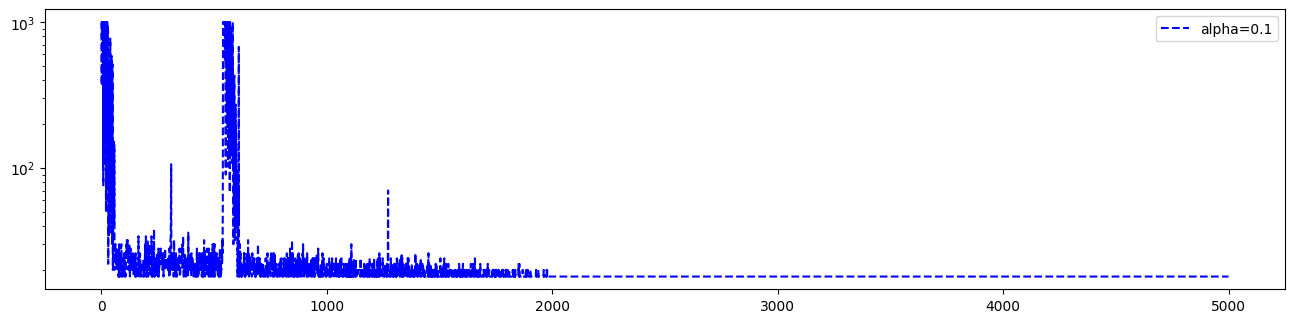

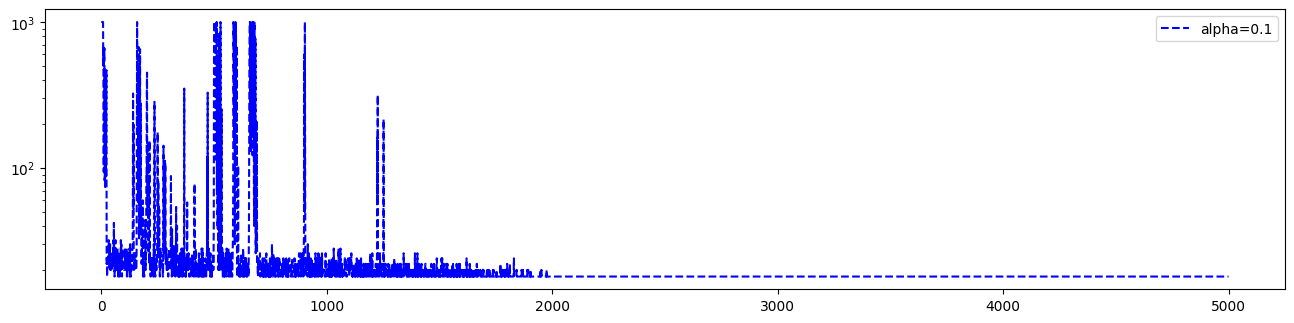

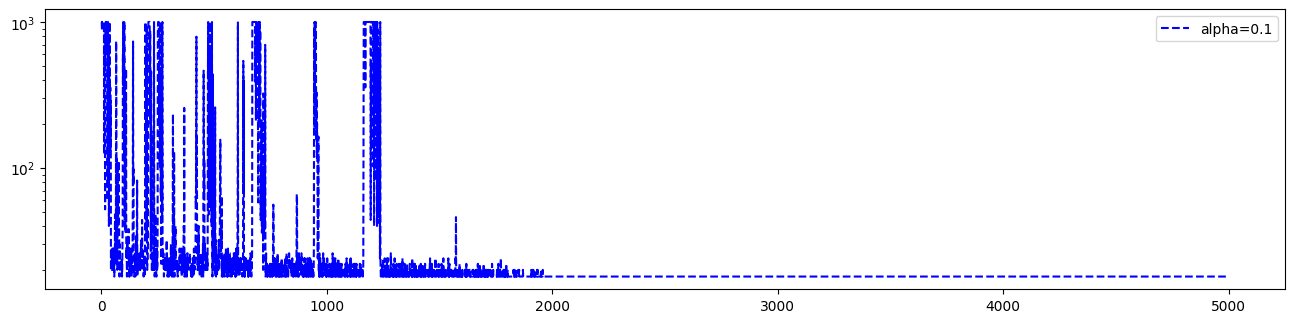

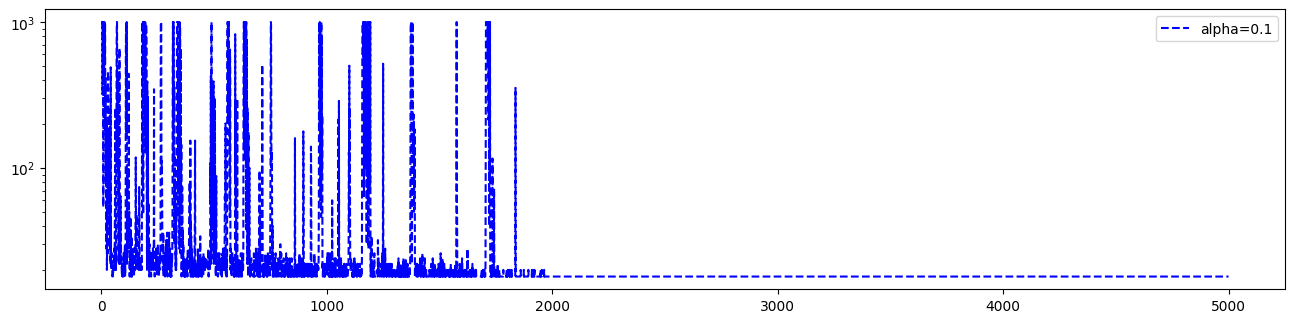

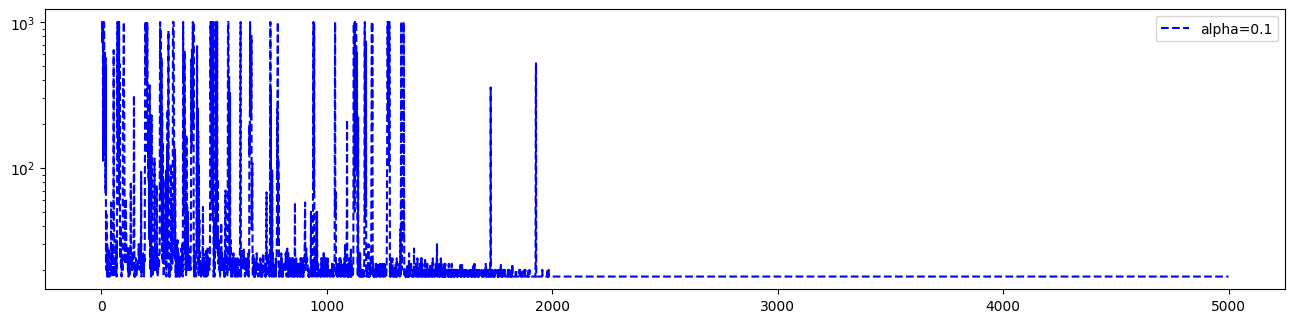

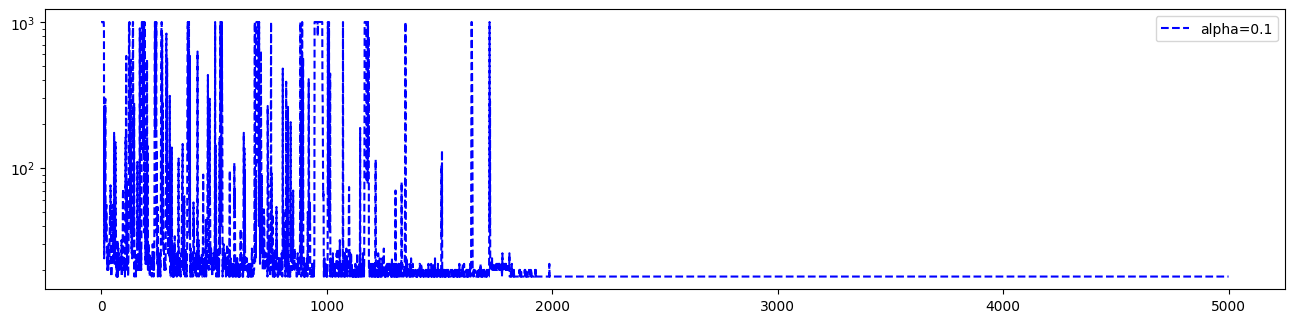

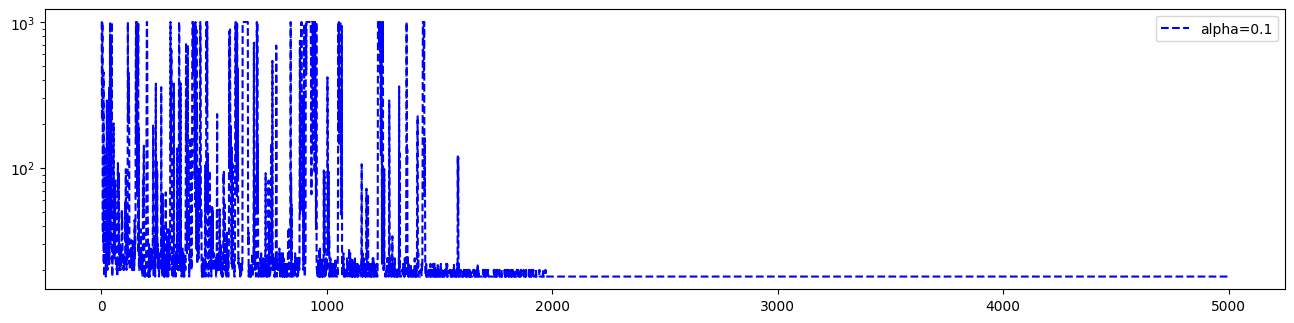

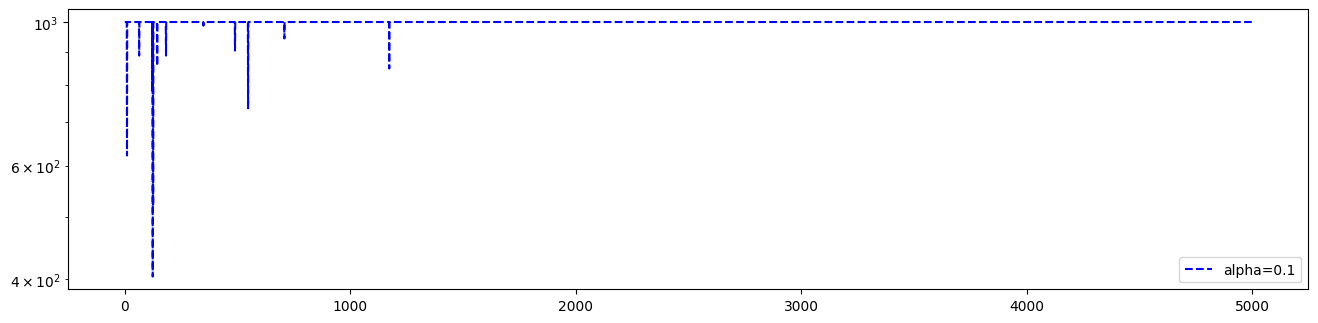

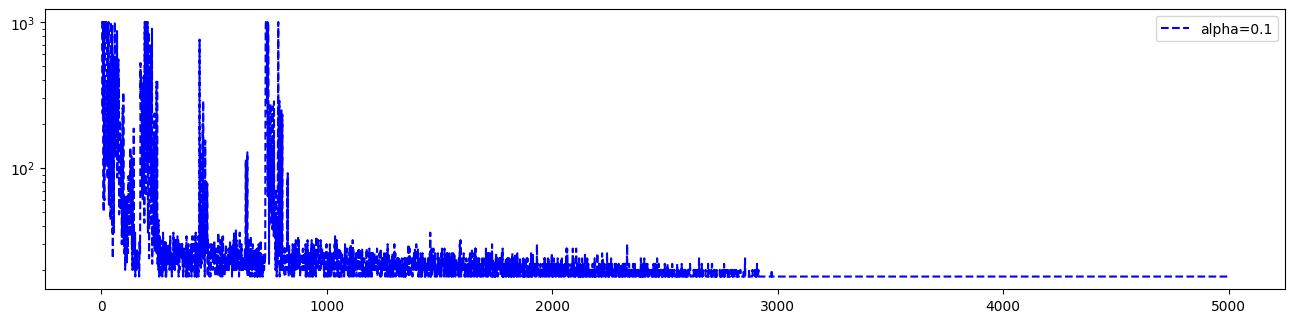

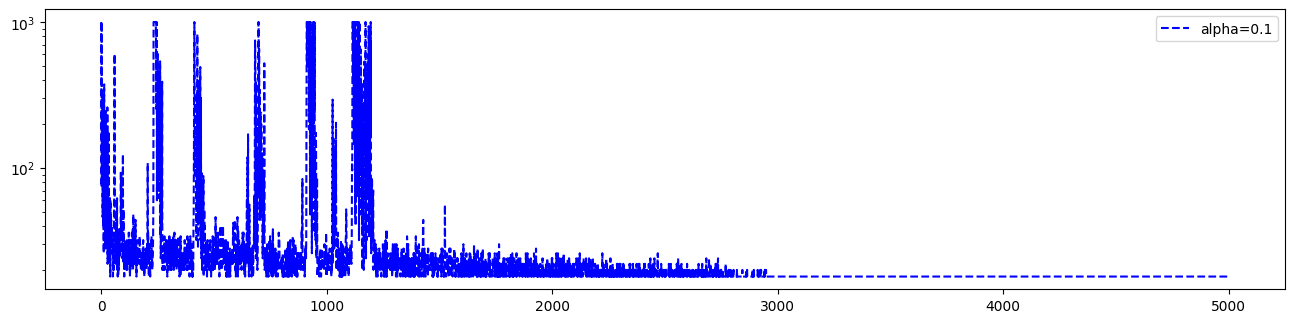

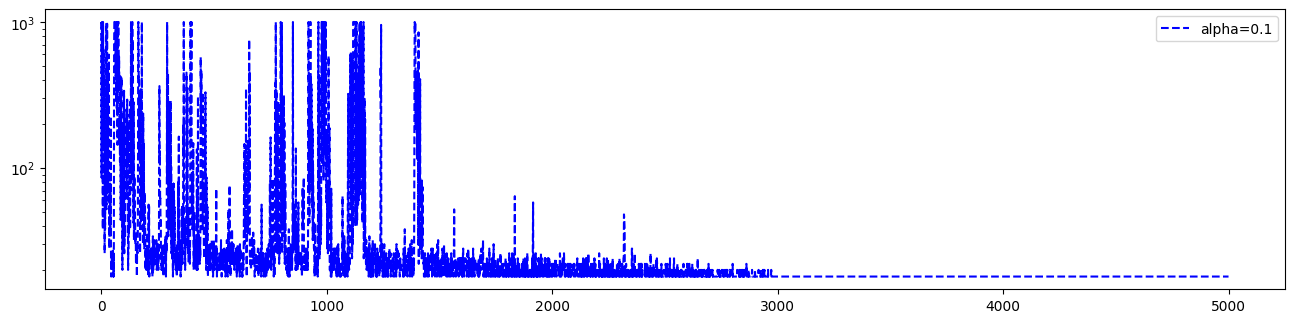

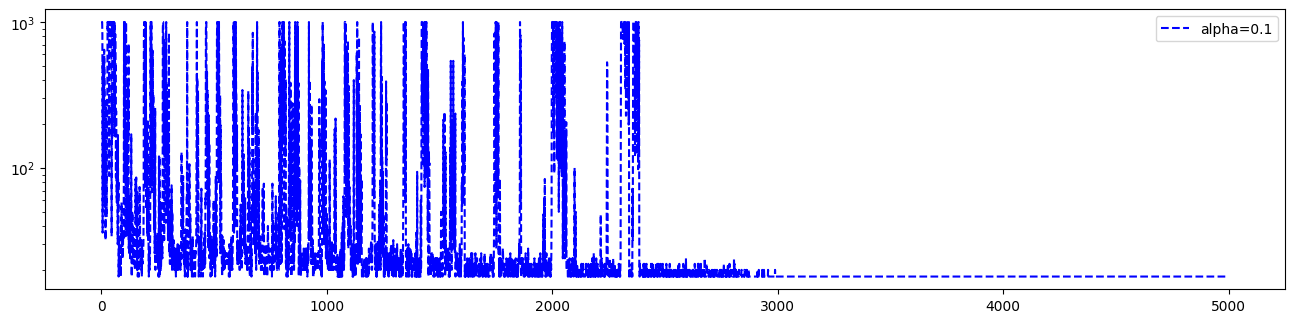

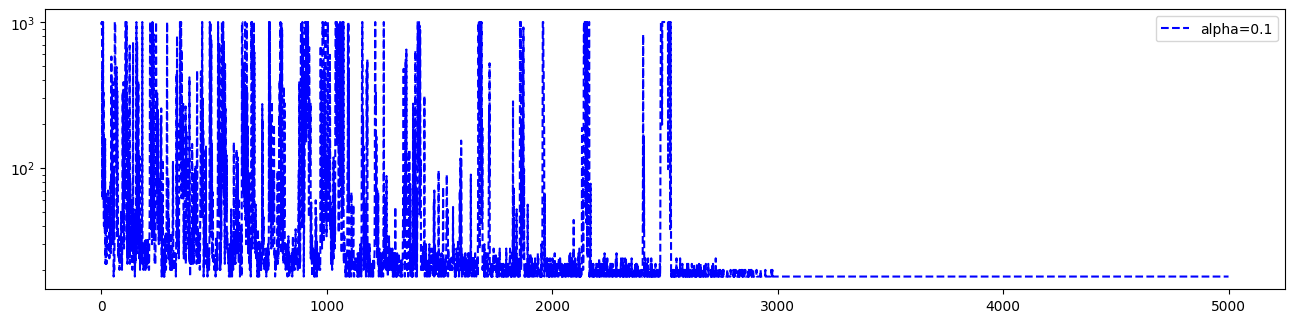

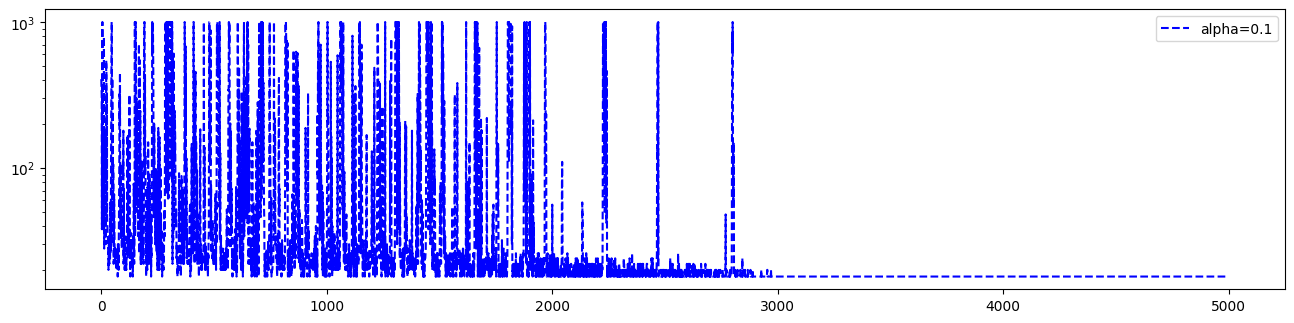

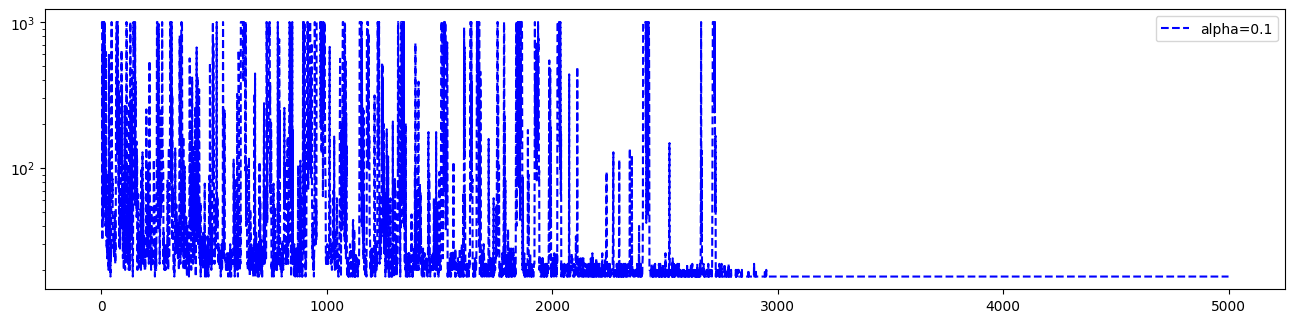

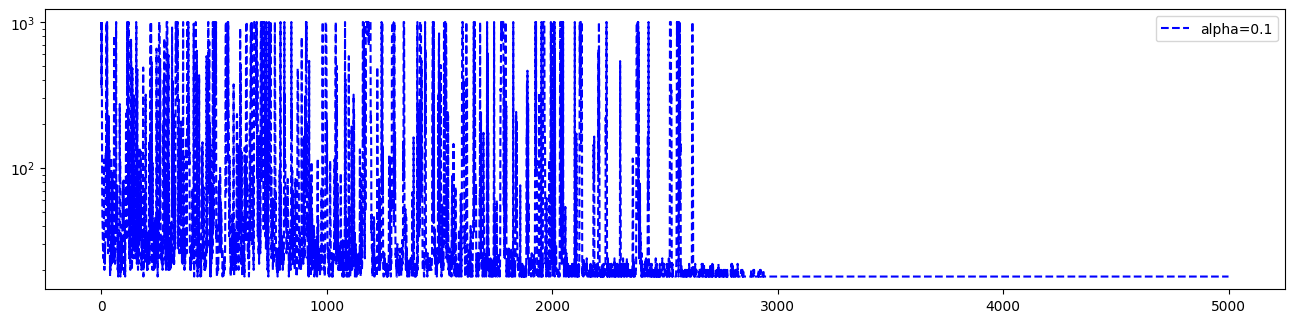

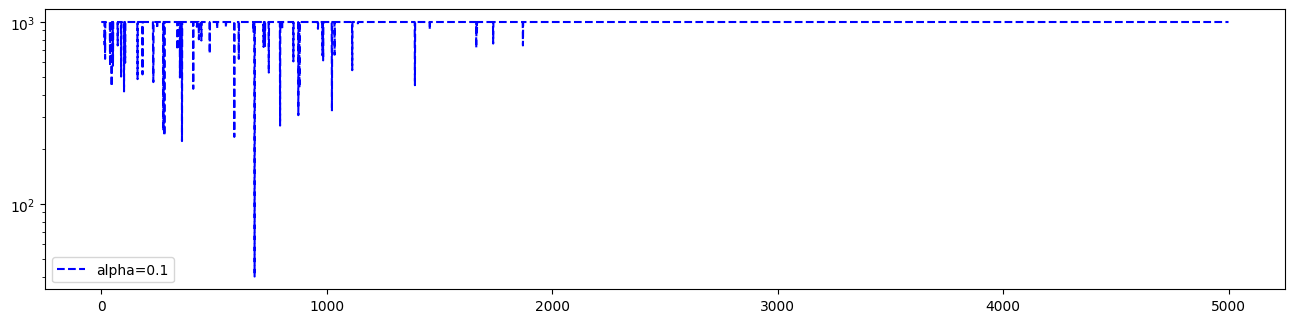

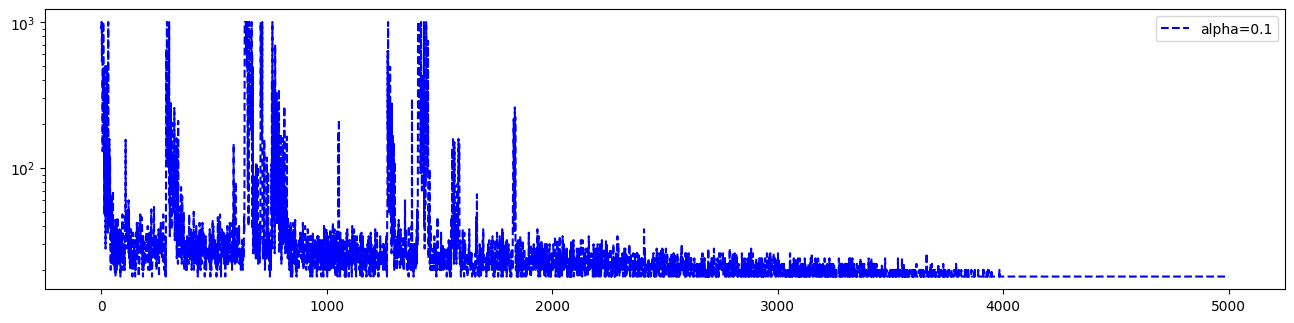

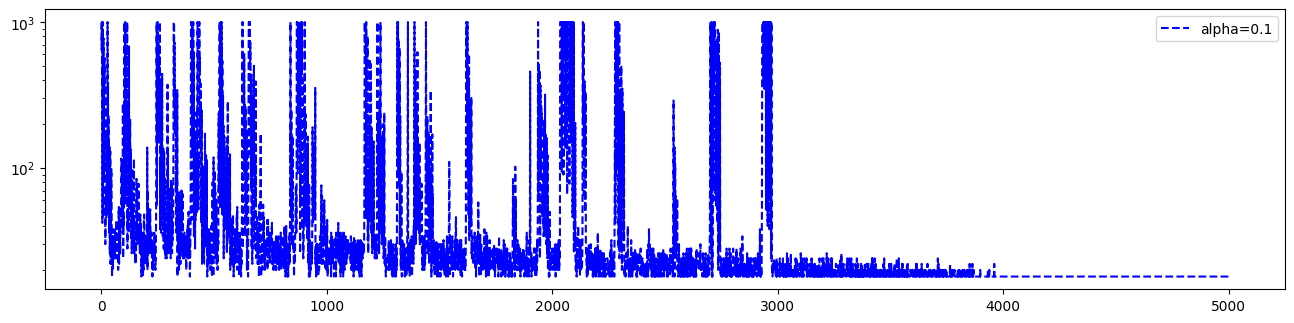

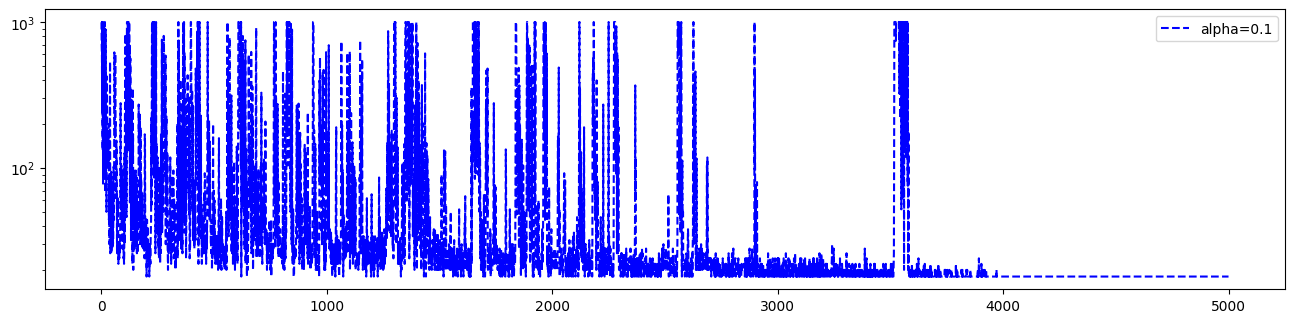

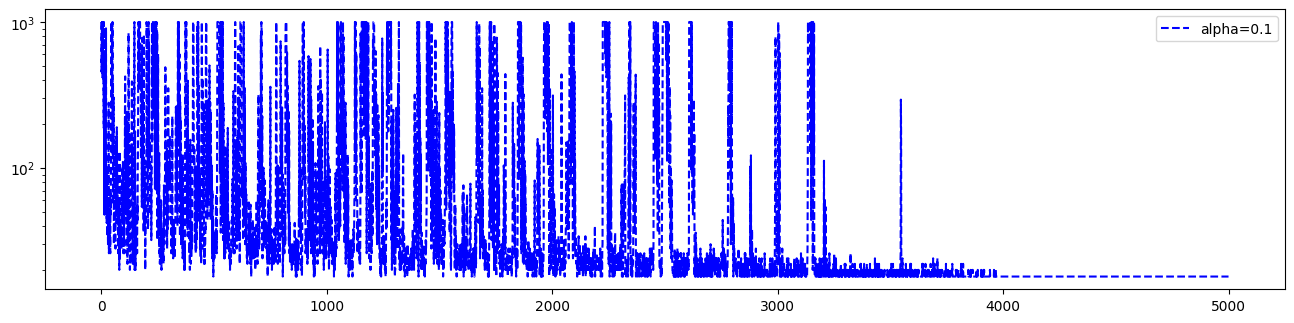

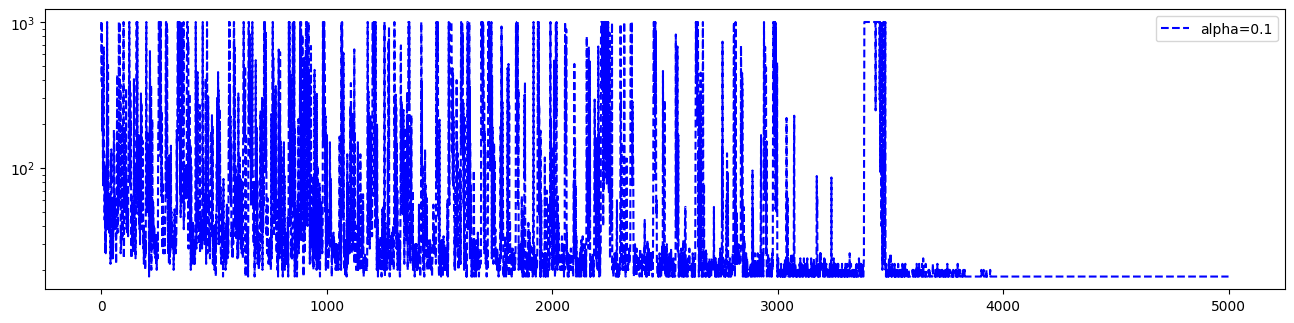

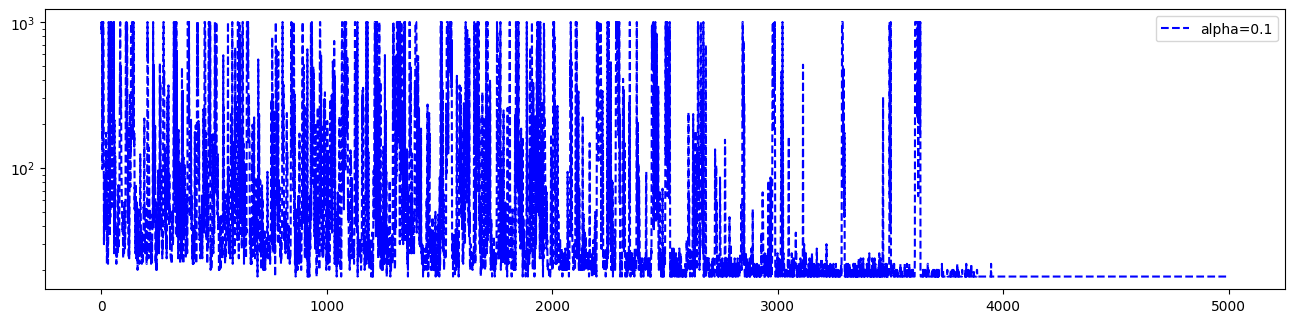

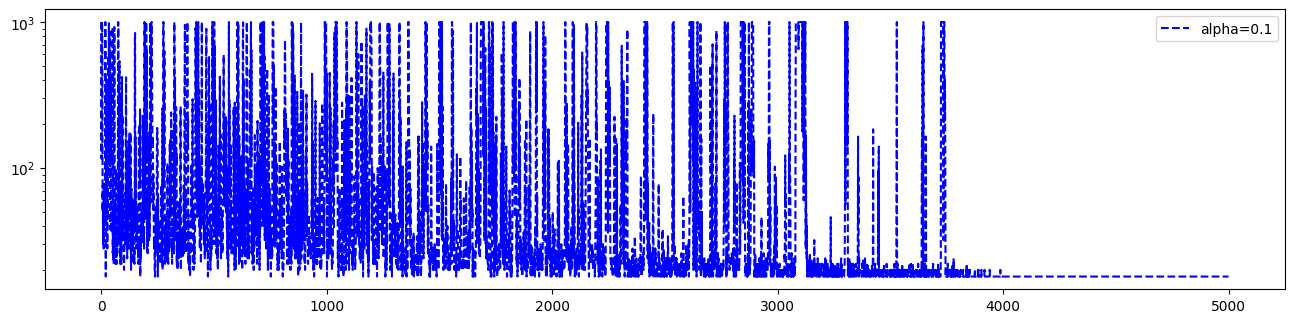

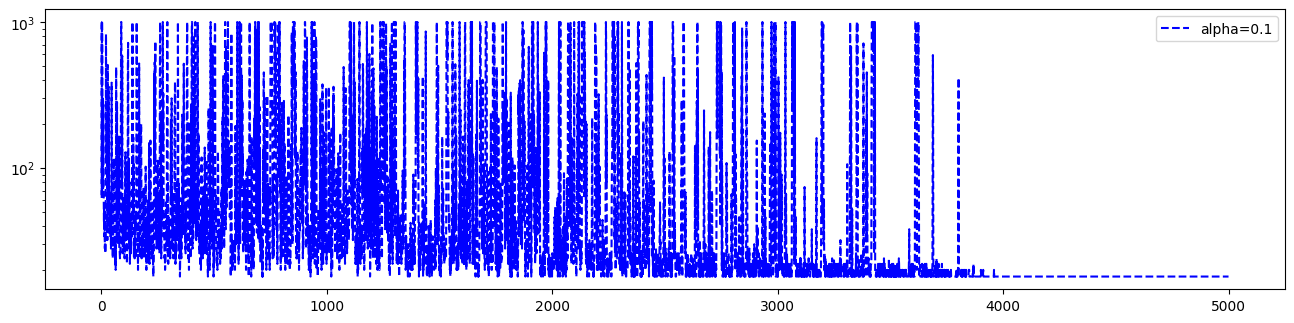

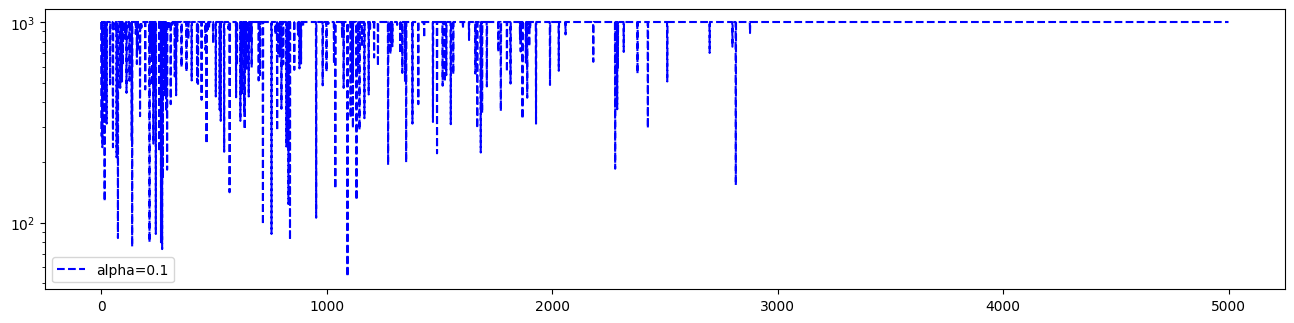

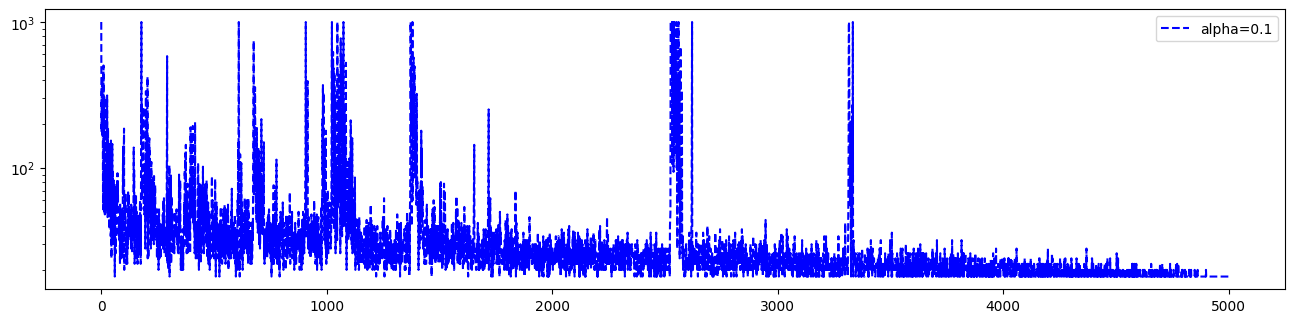

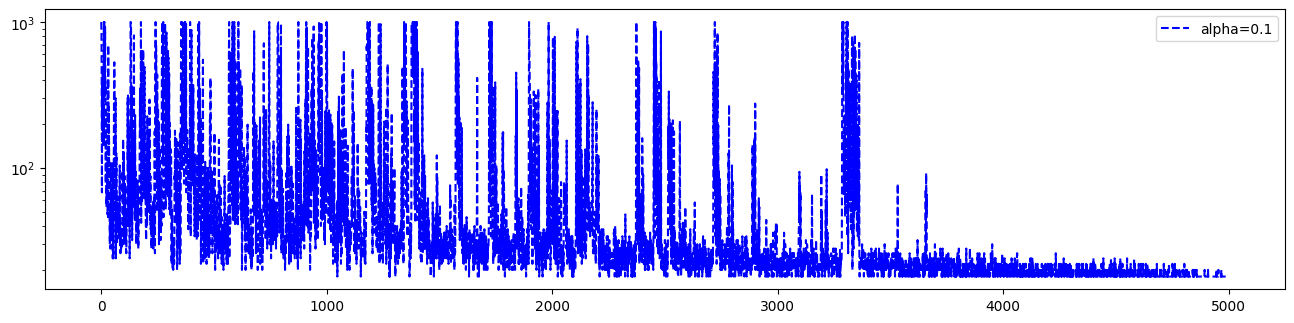

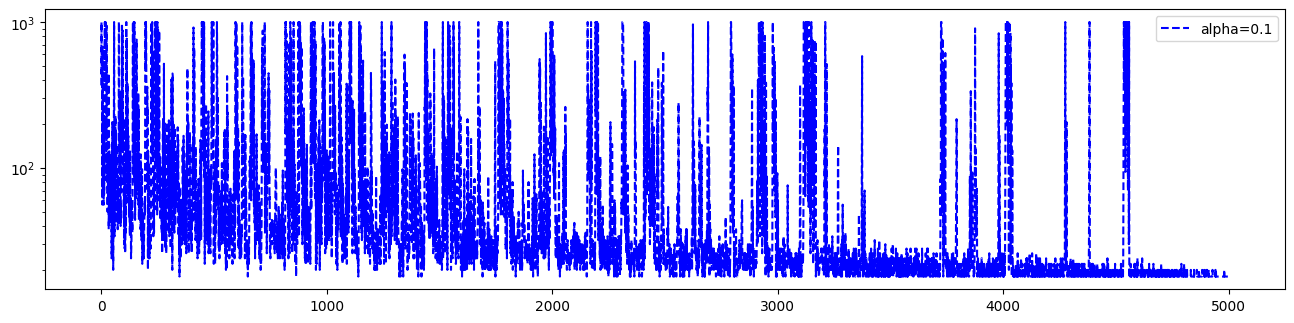

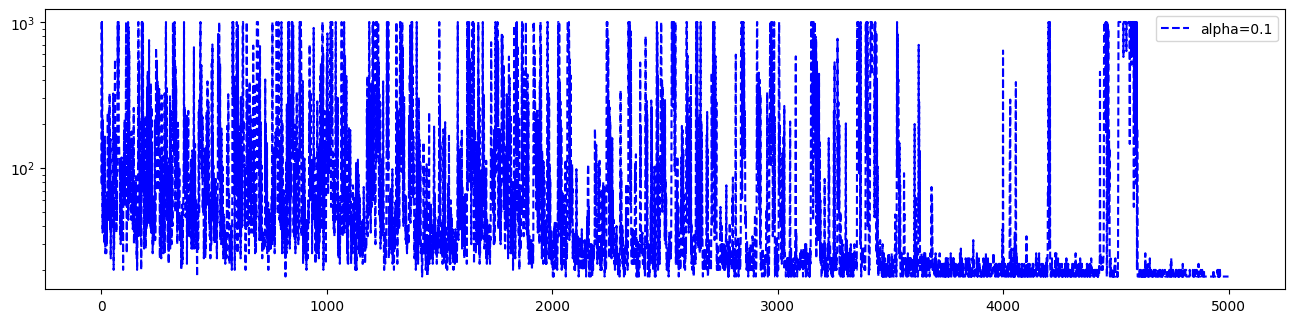

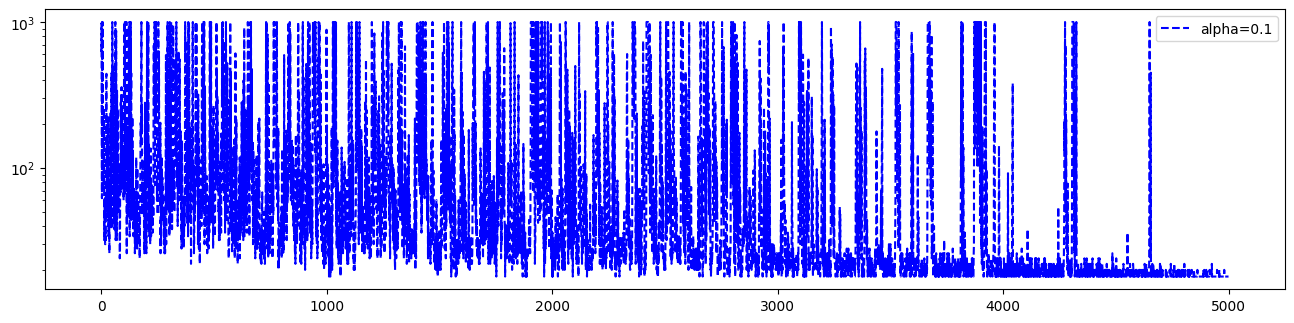

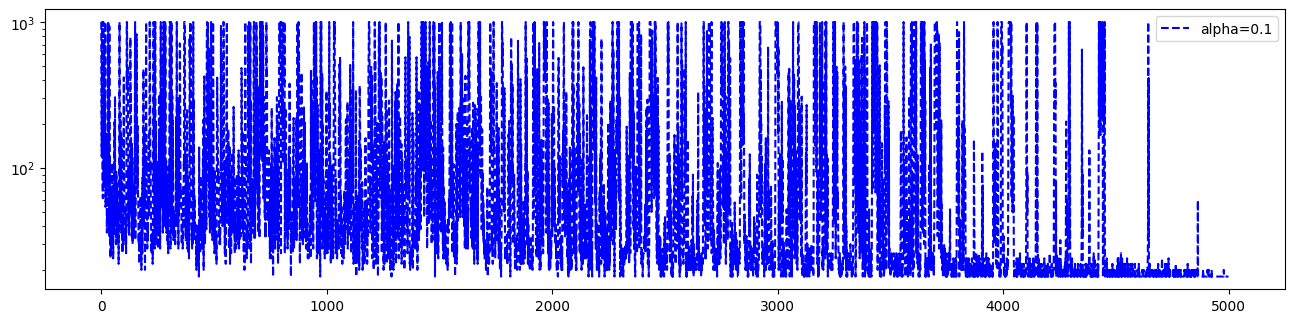

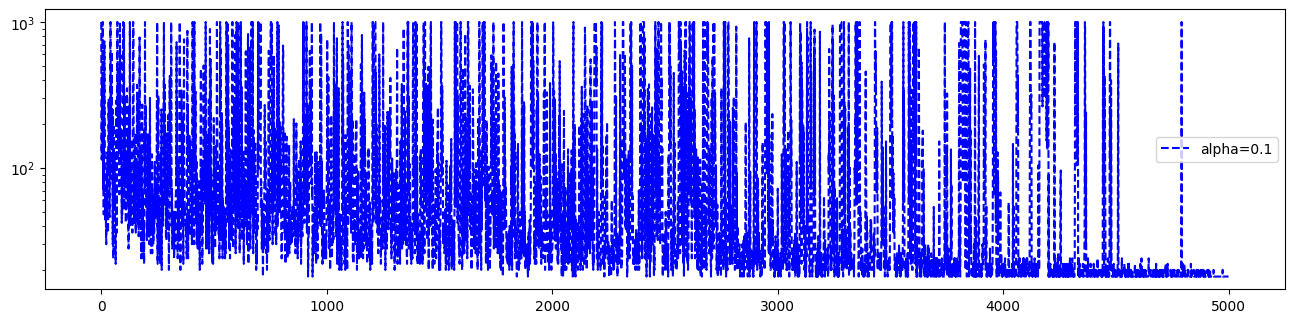

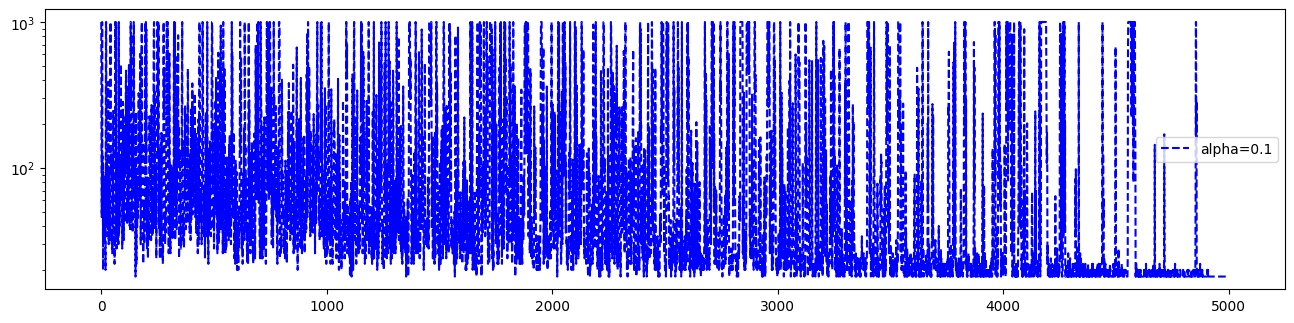

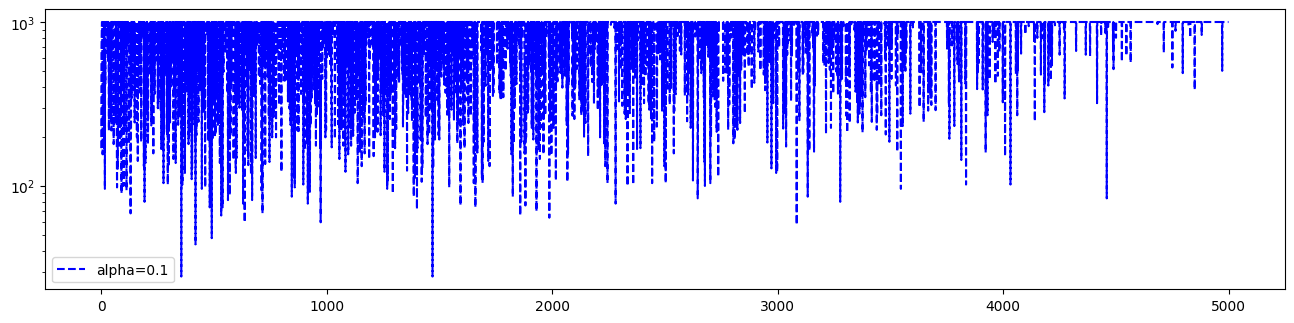

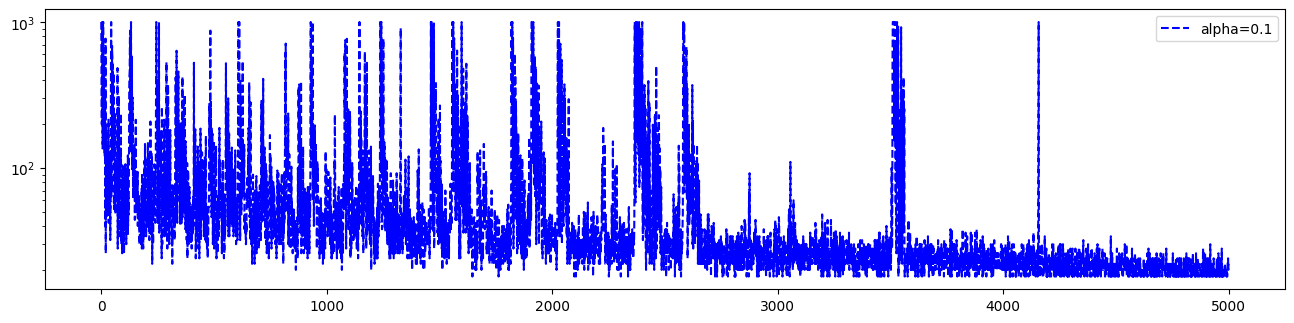

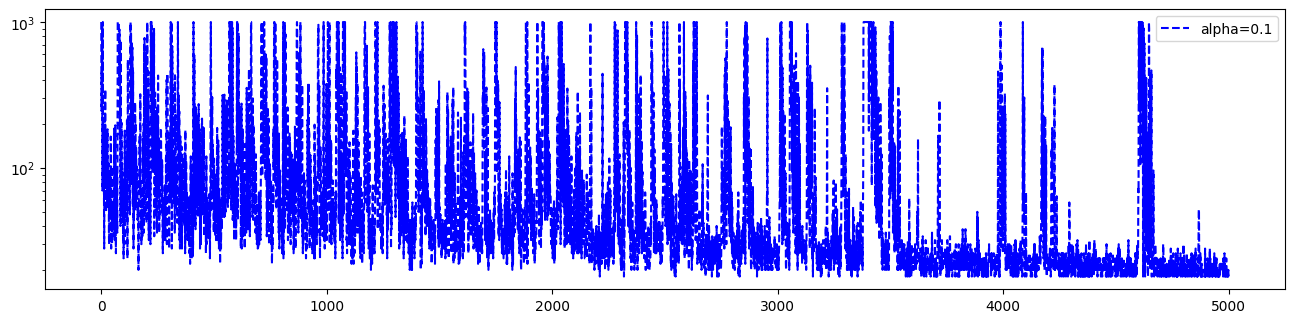

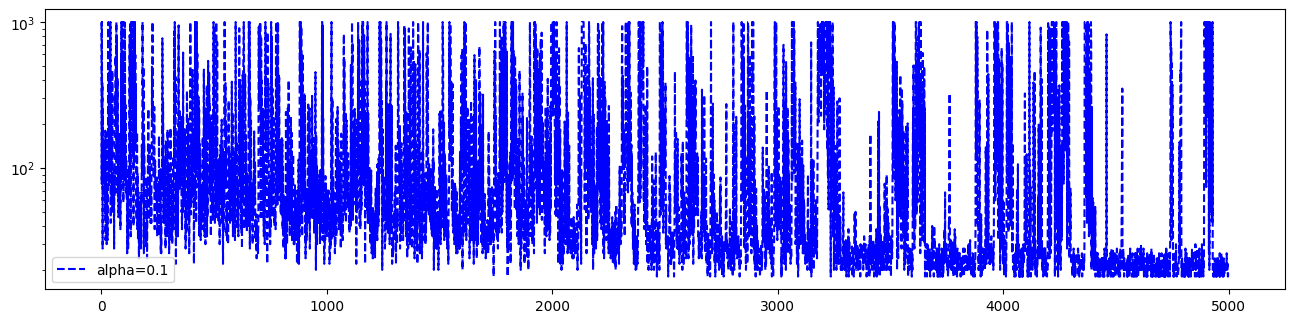

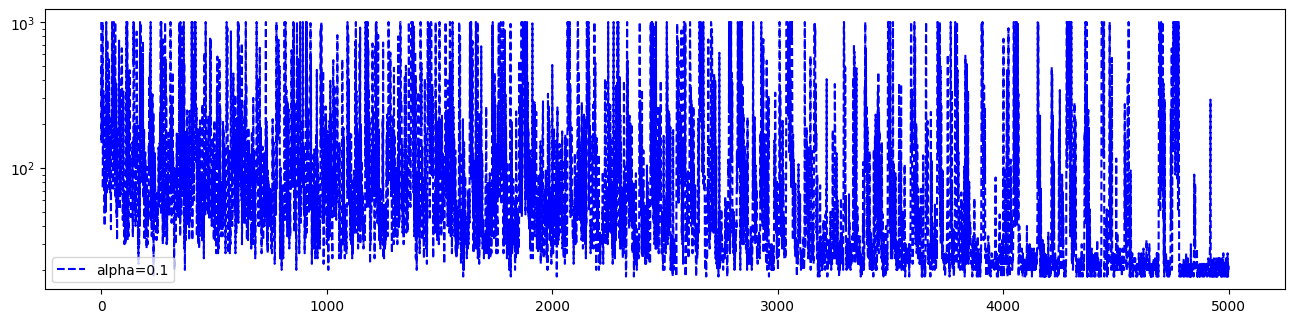

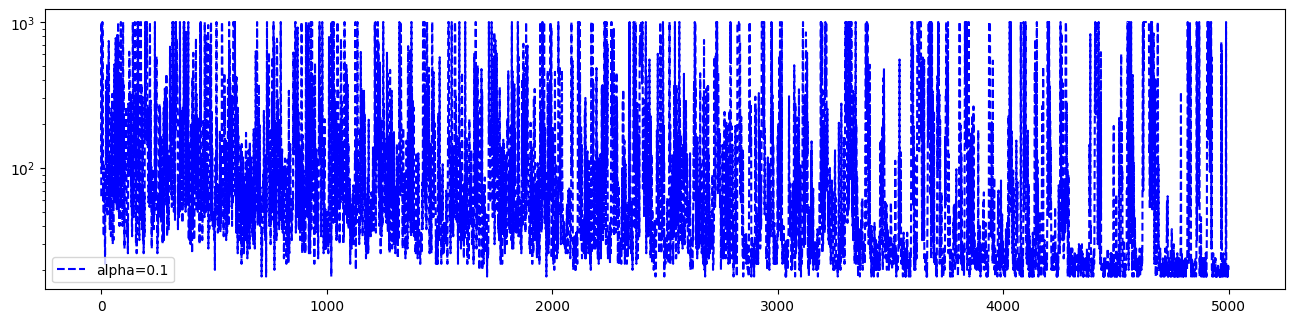

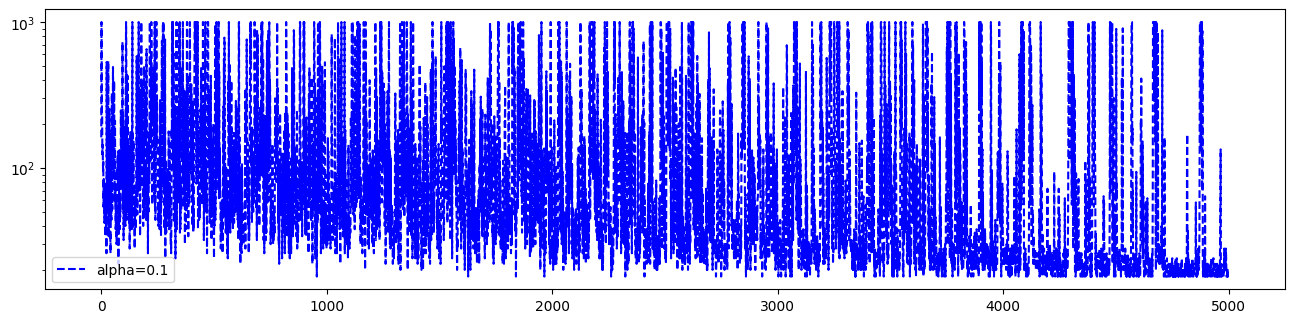

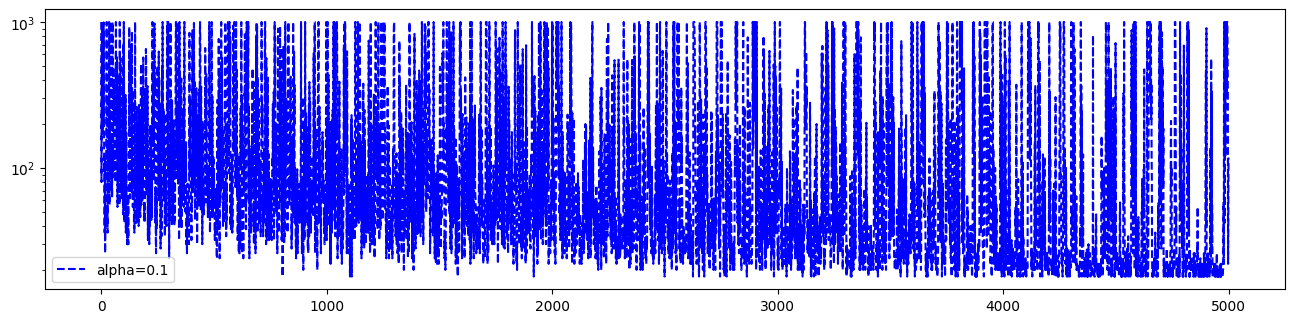

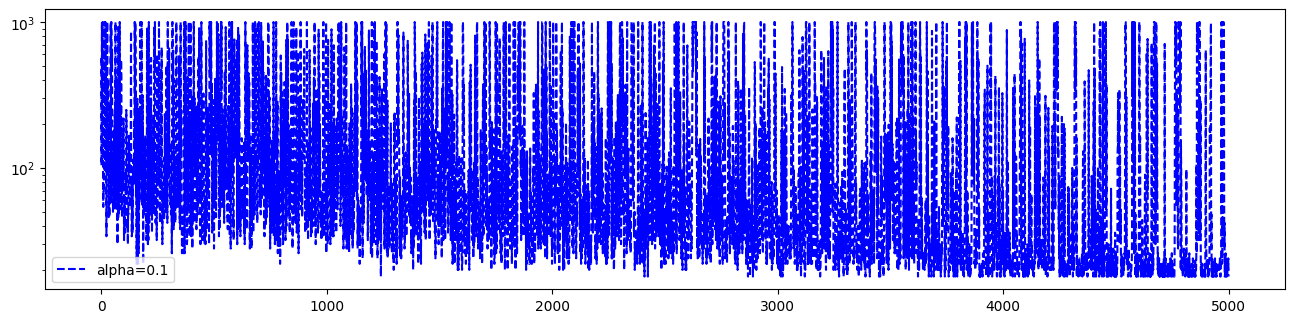

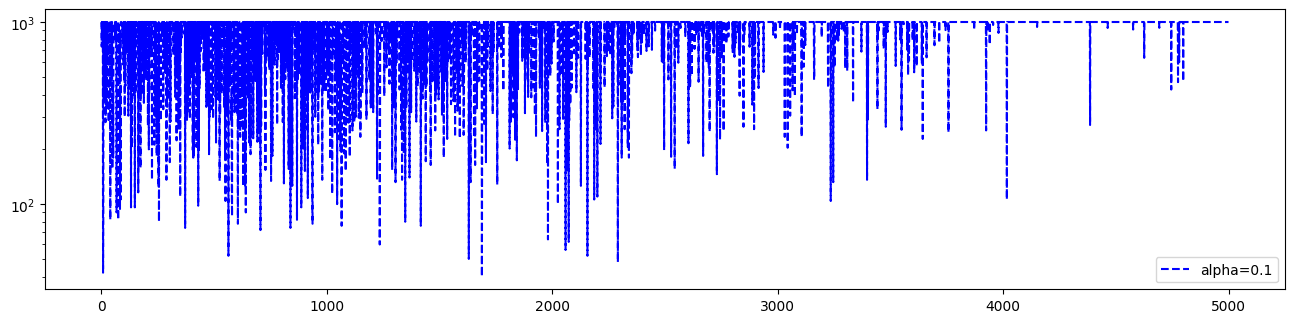

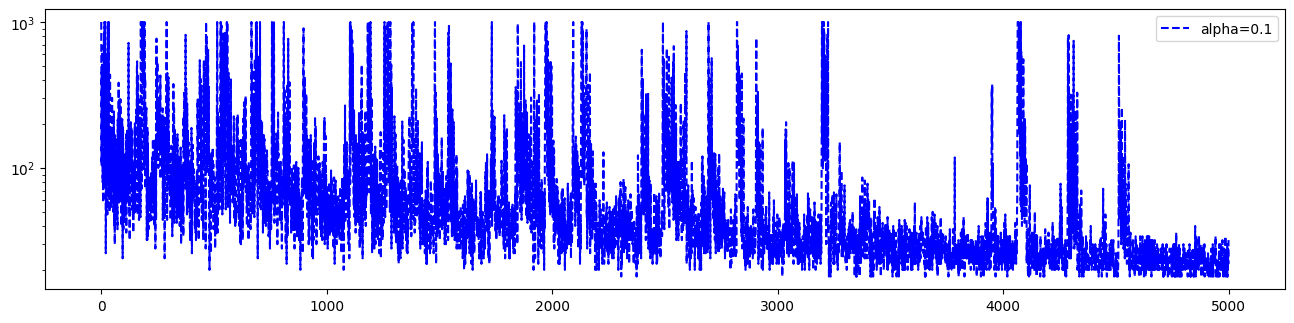

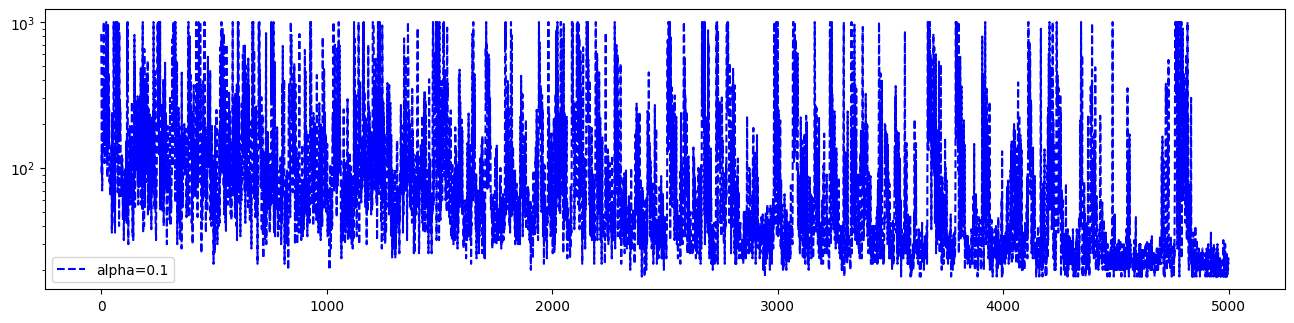

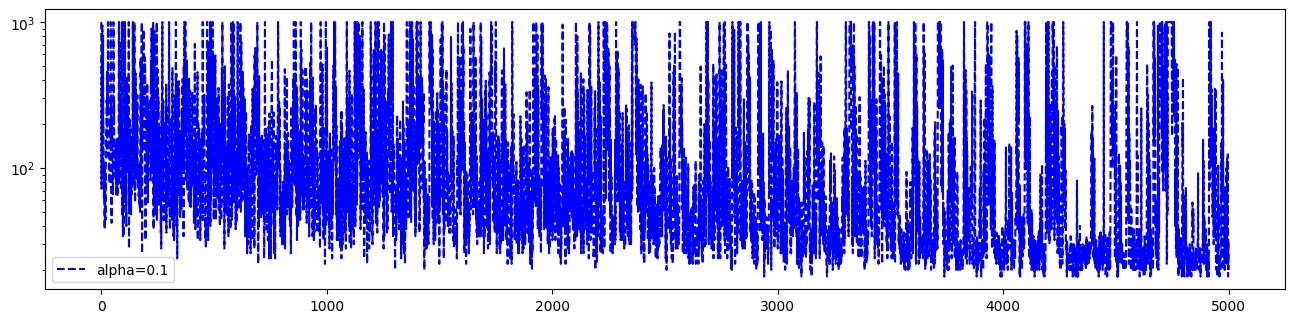

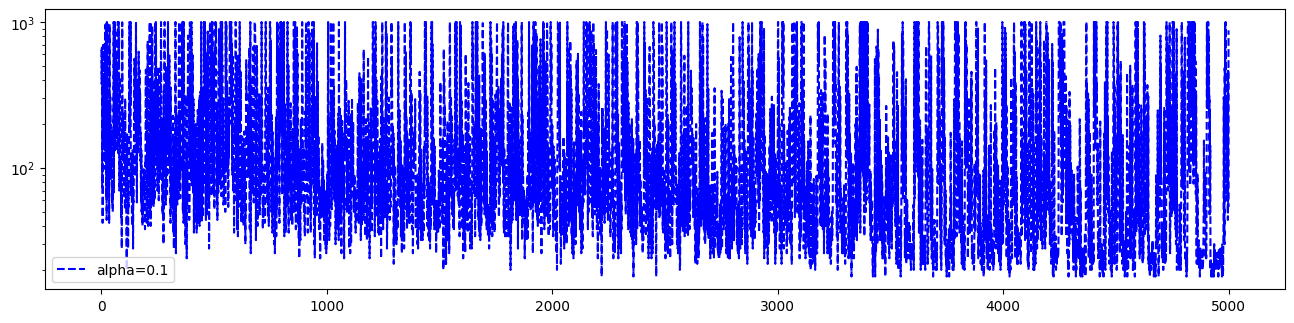

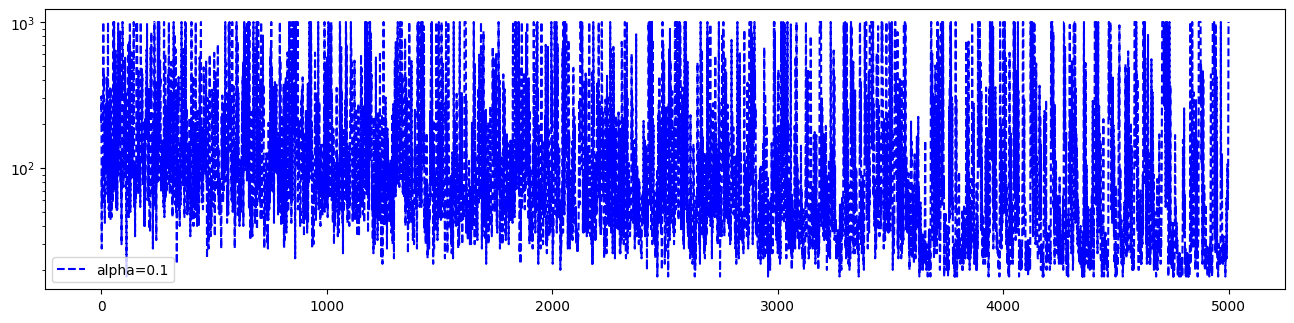

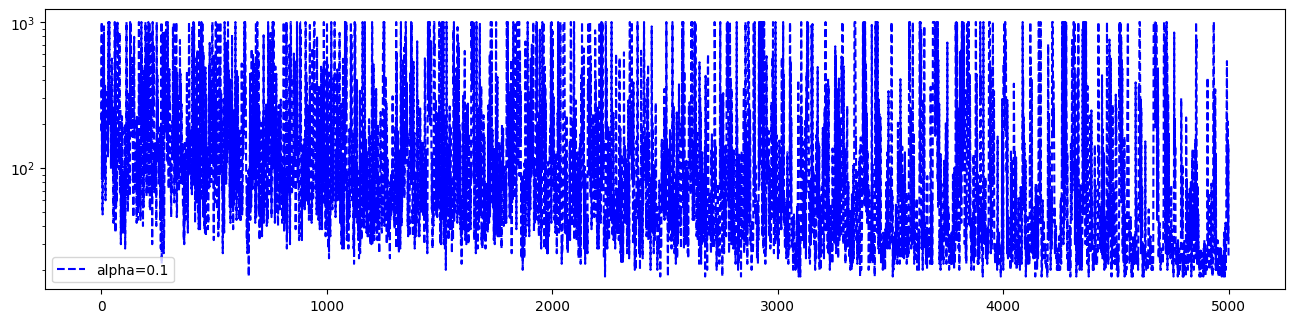

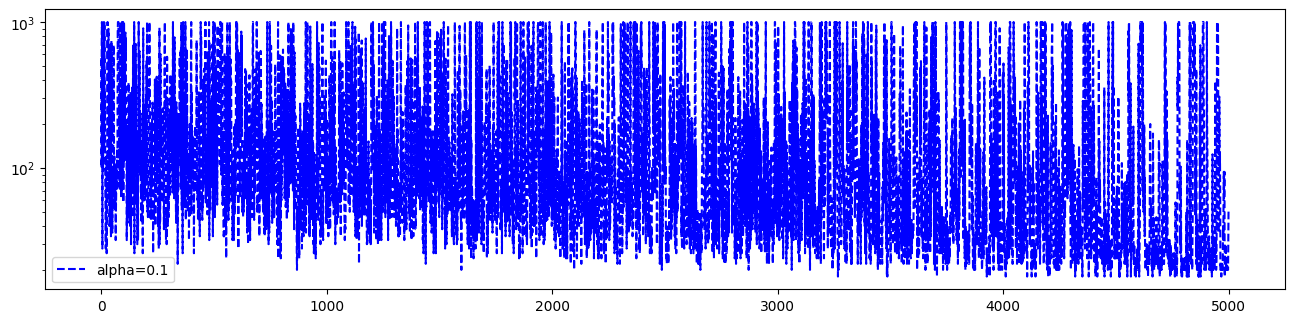

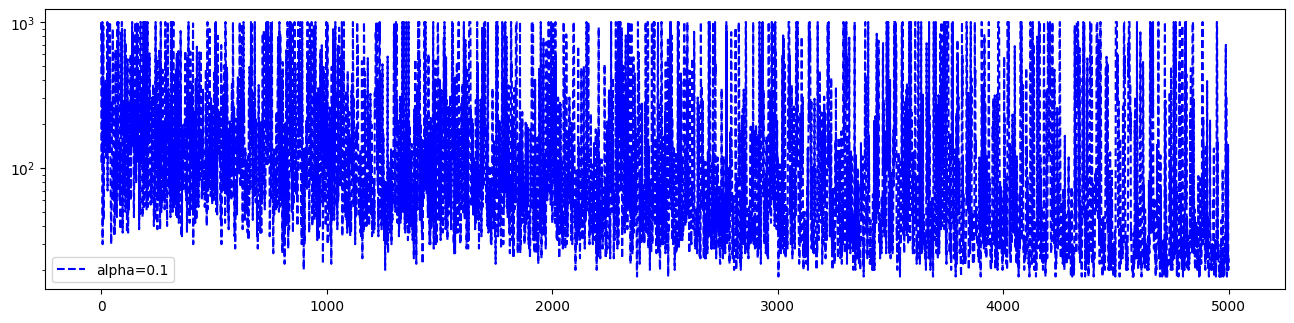

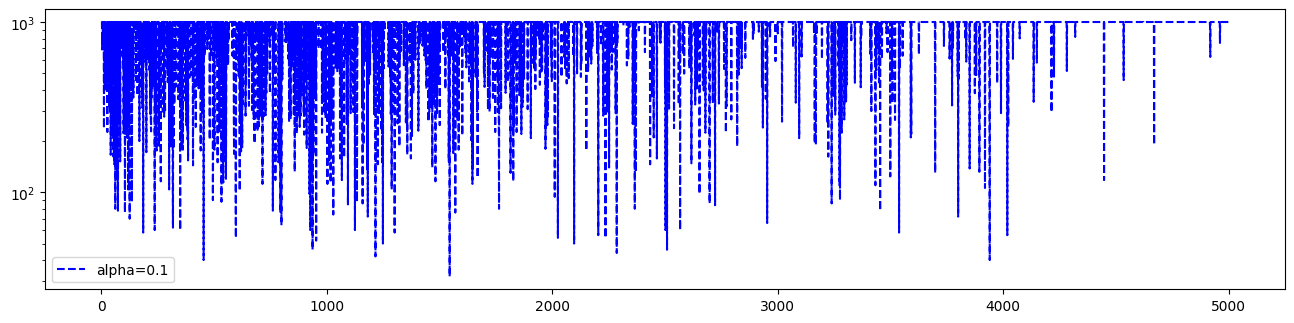

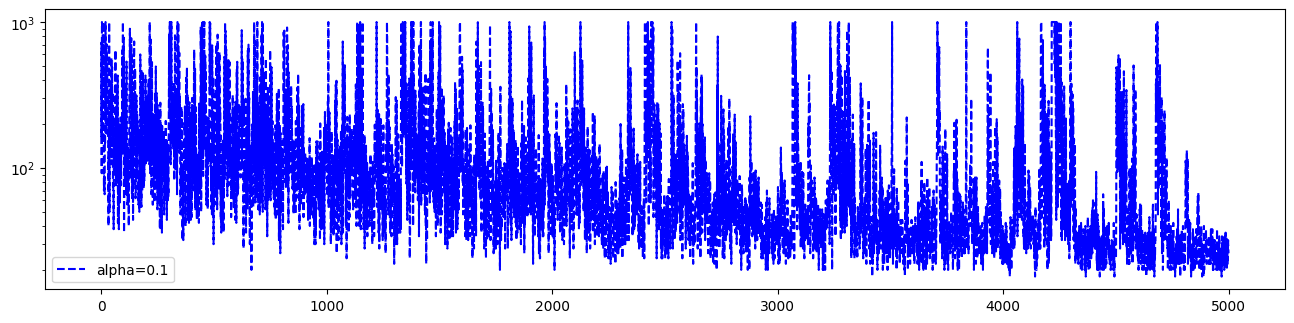

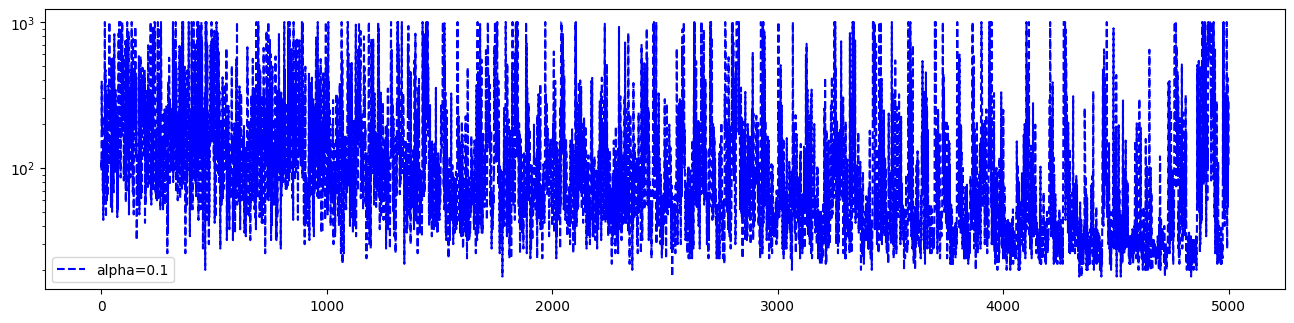

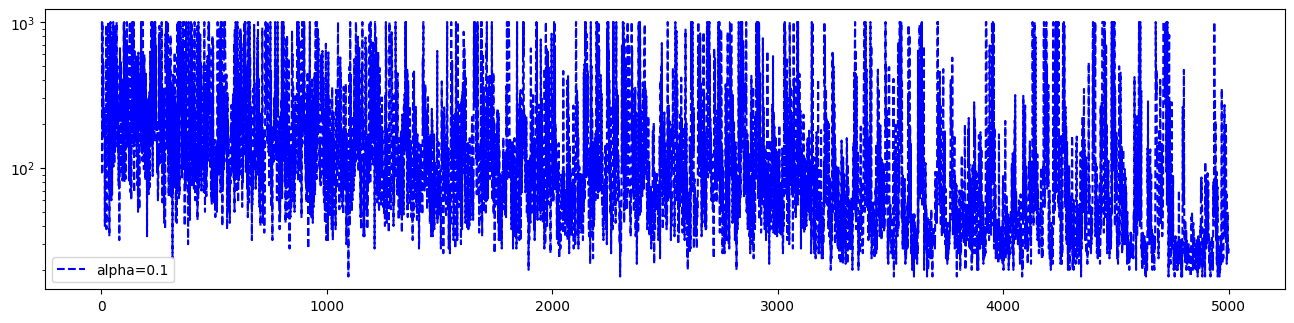

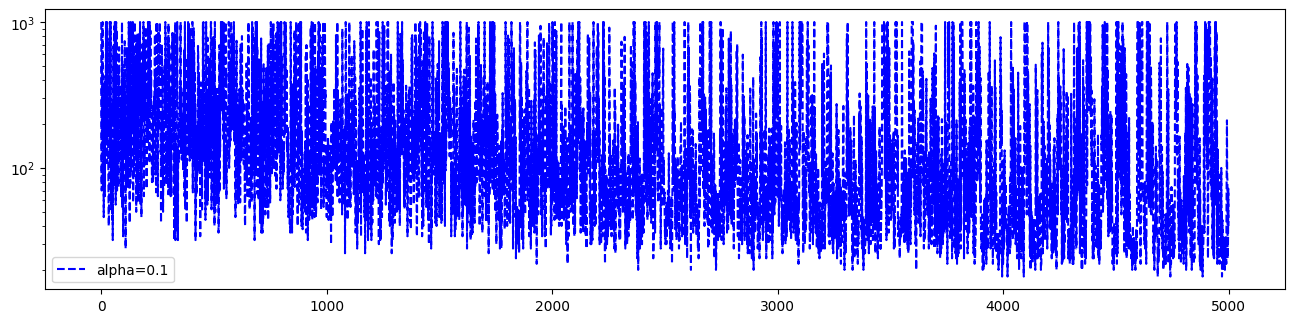

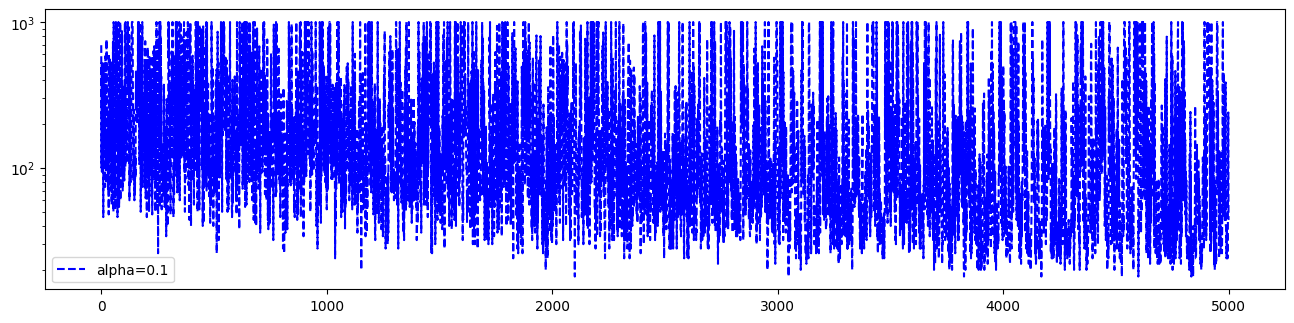

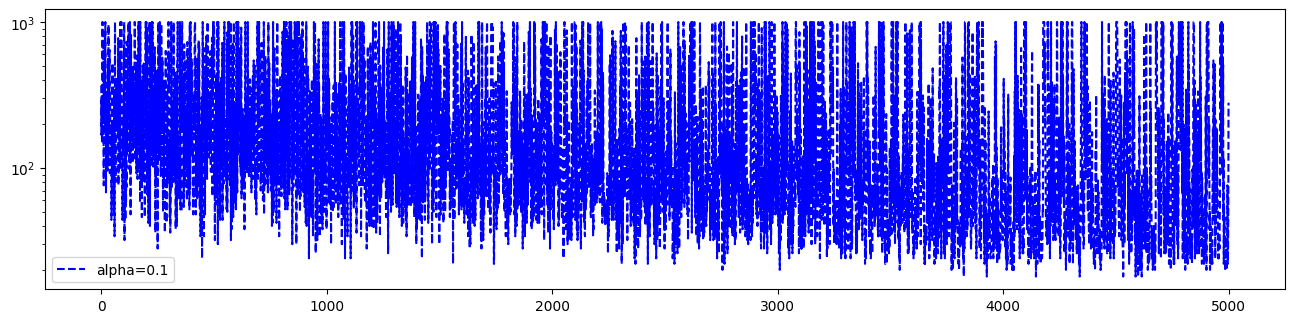

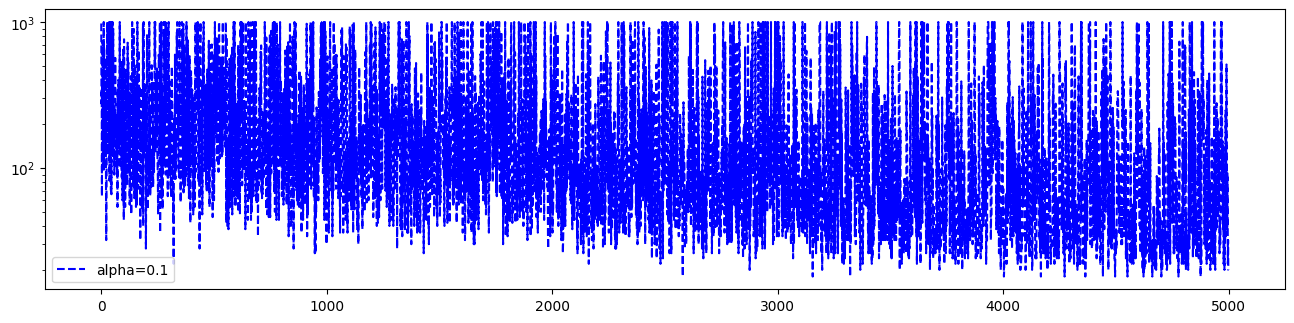

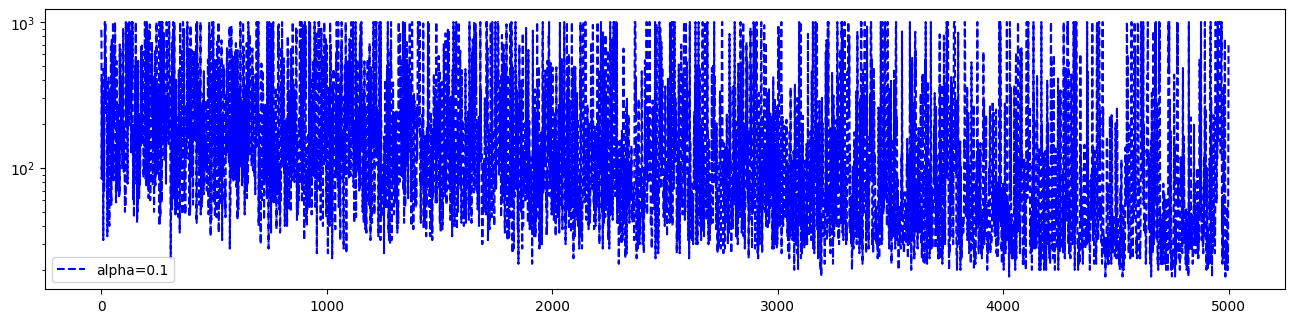

In [12]:
randowmF_A()